In [1]:
import os
import pandas as pd
import itertools
pd.options.mode.chained_assignment = None  # default='warn' #turn off the SettingWithCopyWarning
import numpy as np
import math
import requests

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.dates import YearLocator, DateFormatter
#%matplotlib notebook

import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date

from dateutil.relativedelta import relativedelta

import scipy
from scipy import stats

# from IPython.display import display, HTML
# display(HTML(data=""" <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 85%; }
#     div#maintoolbar-container { width: 99%; } </style> """))

## Important Data Paths

In [2]:
#Water Level Data Downloads:
#Choose date of WL data download and path for USGS and UHSLC data
date = '2024-11-04'
UHSLC = os.path.join("..", "Data", "WL_Data{}".format(date), "UHSLC")
USGS = os.path.join("..", "Data", "WL_Data{}".format(date), "USGS")

#Outputs Path
figures_path = os.path.join(".", "Outputs", "Figures")
tables_path = os.path.join(".", "Outputs", "Tables") #.to_csv(os.path.join(tables_path, 'test.csv'))

## Read in RAW WL Measurement and Station Metadata Files from Download

In [3]:
#read the USGS files
RAW_WL_data = {}
for file in os.listdir(USGS):
    df = pd.read_csv(os.path.join(USGS, file), low_memory=False)
    data = pd.DataFrame()
    data['data'] = df['value']
    data['date'] = df['dateTime']
    RAW_WL_data[file.split('.')[0]] = data

#read the UHSLC files
for file in os.listdir(UHSLC):
    df = pd.read_csv(os.path.join(UHSLC, file), low_memory=False)
    data = pd.DataFrame()
    data['data'] = df['data']
    data['date'] = df['date']
    RAW_WL_data[file.split('.')[0]] = data

#delete the test station on OAHU as it is on campus and not in a reservoir
del RAW_WL_data['EDD11398']

Station_Meta = pd.read_csv('station_meta.csv')   ## Download the metadata
#meta.columns = df.columns.str.replace('geometry.', '', regex=False).str.replace('properties.', '', regex=False)  # clean up column headers 

## Resample data to daily measurements, change units, and set correct datetime

In [38]:
#change units to feet, get rid of nonrepresentative data, and resample to daily averages
daily_WL = {}

for ID in RAW_WL_data:
    RAW_WL_data[ID]['date'] = pd.to_datetime(RAW_WL_data[ID]['date'])
    data = RAW_WL_data[ID].copy()

    # Data now comes in with a timezone aware index and in GMT, as its easier to work in HST, just remove timezone and convert to HST 
    data = data.set_index('date')
    data = data.tz_localize(None)         # Scrub out the Timezone awareness of the index 
    data = data.shift(-10, freq='h')  # Shift the timestamp back 10 hrs 
    
    #Turn None into NaN values
    data = data.replace(-66577, np.nan)
    data = data.replace(131071, np.nan)
    data = data.replace(-999999.00, np.nan)
    
    # Convert from decimal feet to ft for all UHSLC data. 
    if 'E' in ID:
        data['data'] = data['data']/100

    data_daily =  data.resample('1D').mean() 
    
    # record daily files in a dictionary of dataframes
    daily_WL[ID] = data_daily

# Remove Outliers: exclude data with sudden drops in WL and shifts in datums

In [39]:
#fix datum shifts and weird drops in WL readings

#List of reservoirs with outlier drops in WL and changes in datums
#numbers in batt_er are the minimum WL measurement to exclude outlier drops
batt_er = {'EDD00214' : 11, 'EDD024F8' : 381, 'EDD02A2A' : 925, 'EDD05268' : 22, 'EDD067F2' : 4, 'EDD099A4' : 159.9, 'EDD0BF48' : 12, 'EDD0C70A' : 10, 'EDD0C9D8' : 3}
datum_shifts = ['EDD06920', 'EDD07484', 'EDD08400']
Station_Meta = Station_Meta.set_index('id')
#fix the datum shifts
fixed_datum = {}
for id in datum_shifts:
    alert_start = Station_Meta['properties.level_alert_on'][id]
    threshold = 20 # this is the change in water level around the datum reference (here we use the alert level on)
    data = daily_WL[id].copy()
    for i in data.index:
        if (data.data[i] > (alert_start - threshold)) & (data.data[i] < (alert_start + threshold)) :
            data.loc[i, 'data'] = data.data[i].copy()
        else:
            
             data.loc[ i, 'data'] = np.nan
        fixed_datum[id] = data.copy()

#fix the sudden drops in data 
fixed_drop = {}
for key in daily_WL.keys():
    if key in batt_er.keys():
        min_val = batt_er[key] #visual observation of bottom WL measurement
        data = daily_WL[key].copy()
        ommitted_data = []
        for i in data.index:
            if data.data[i] < min_val:
                ommitted_data.append(np.nan)
            else:
                ommitted_data.append(data.data[i])
        data.data = ommitted_data
        fixed_drop[key] = data.copy()
    

#Update the existing dataset
daily_WL_ommitted = {}
for ID in daily_WL:
    if ID in batt_er.keys():
        daily_WL_ommitted[ID] = fixed_drop[ID]
    elif ID in datum_shifts:
        daily_WL_ommitted[ID] = fixed_datum[ID]
    else:
        daily_WL_ommitted[ID] = daily_WL[ID]

Station_Meta = Station_Meta.reset_index()


# Plot graphs just to check

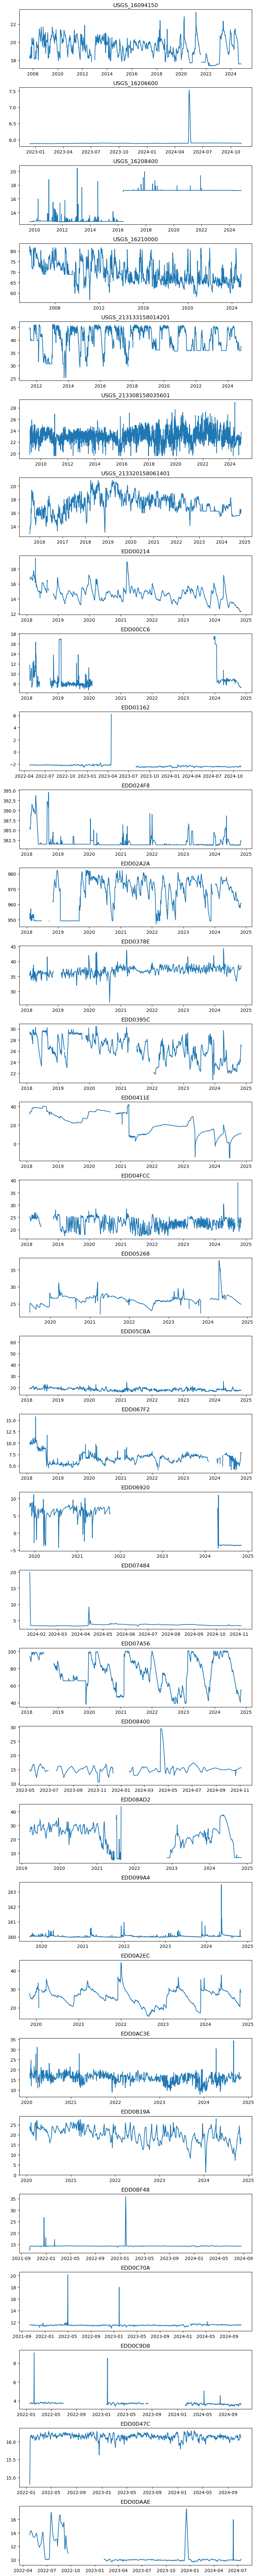

In [40]:
fig, ax = plt.subplots(len(daily_WL_ommitted), figsize = (8, 80))
i=0
for key in daily_WL_ommitted:
    ax[i].plot(daily_WL_ommitted[key].index, daily_WL_ommitted[key].data)
    ax[i].set_title(key)
    i+=1
fig.tight_layout()

# Determine the start date, end date of data, duration, and completeness (UHSLC datum change doesn't matter for this one)

In [41]:
def reservoir_WL_metadata(Raw_WaterLevel_data, Ommitted_WL_data, WaterLevel_dates):
    WaterLevel_dates = pd.to_datetime(WaterLevel_dates)
    
    #end and start date
    end_date = Raw_WaterLevel_data.index.max()
    start_date = Raw_WaterLevel_data.index.min()
    
    #calculate total duration of data
    duration = (end_date - start_date)/np.timedelta64(1, 'D')/365
    
    #calculate percent completenes
    n_total_datas = len(Raw_WaterLevel_data)
    total_nan = np.count_nonzero(np.isnan(np.array(Ommitted_WL_data))) #count number of values in array equal to NaN
    completeness = 1 - total_nan / n_total_datas
    
    df = pd.DataFrame({'end_date': end_date , 'start_date' : start_date, 'duration' : duration, 'completeness' : completeness}, index = [0])
   
    return df

In [42]:
#calculate the duration, start , end, completeness
Reservoir_WL_completness = {}
for file in daily_WL_ommitted:
    #get a list of the water level data and dates recored for function above
    Raw_WaterLevel_data = daily_WL[file].copy()
    Ommitted_WL_data = daily_WL_ommitted[file].data
    WaterLevel_dates = daily_WL[file].index
    #use the function above to figure out duration, sstart, end, completness
    Reservoir_WL_completness[file] = reservoir_WL_metadata(Raw_WaterLevel_data, Ommitted_WL_data, WaterLevel_dates)
    
#combine all the reservoir data into one variable
result = pd.concat(Reservoir_WL_completness).rename_axis(['Reservoir_station_file', 'whatever']).reset_index().drop('whatever', axis = 1)


#Create dataframe that shows dlnr id and the data duration, completeness, start, end dates
result['dlnrid'] = np.nan
station_merge_meta = Station_Meta[['properties.dlnrid', 'id']].copy()

# Change the column type to object to hold both strings and numbers if needed
result['dlnrid'] = result['dlnrid'].astype(object)

i = 0
for ID in result.Reservoir_station_file:
    element = ID
    index_location = station_merge_meta.index[station_merge_meta['id'] == element].tolist()
    dlnrid = station_merge_meta['properties.dlnrid'][index_location]
    # Use .loc to avoid chained assignment warning
    result.loc[i, 'dlnrid'] = dlnrid[index_location[0]]
    i += 1

result.to_csv(os.path.join(tables_path, 'reservoir_data_completeness_info.csv'))

# Graph of Total Data Duration and Completeness of Water Level Data

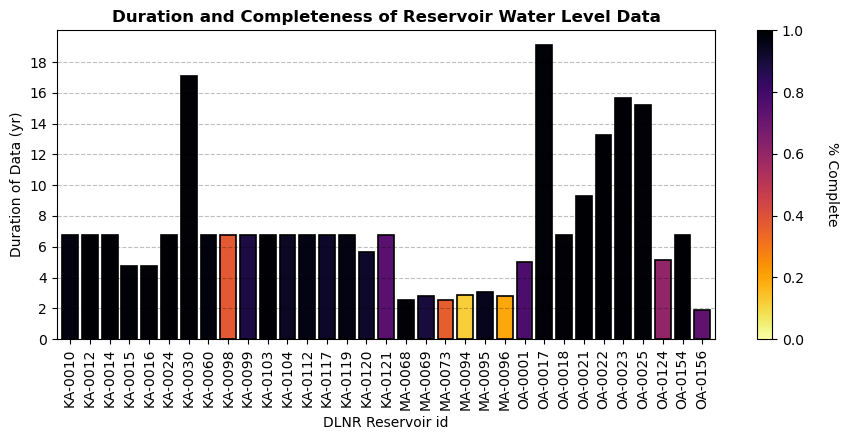

In [43]:
data_info = result  # Assuming result is your data

# Create Barplot:
fig, ax = plt.subplots(figsize=(9, 4.5))

# Creating color map and color data
my_cmap = plt.get_cmap('inferno_r')
data_color = data_info.completeness
normmin = 0
normmax = 1
data_color = [(x - normmin) / (normmax - normmin) for x in data_color]
colors = my_cmap(data_color)

# Normalize for colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Adding colorbar
cbar = plt.colorbar(sm, ax=ax)  # Associating with current axis (ax)
cbar.set_label('% Complete', rotation=270, labelpad=25)

# Bar graphs
data_info = data_info.sort_values(['dlnrid'], ascending=[True])
rects = ax.bar(data_info.dlnrid, data_info.duration, color=colors, edgecolor='black', linewidth=1.2)

# Set ticks
plt.xticks(rotation=90, ha='center')
plt.yticks(np.arange(0, 20, 2))

# The one year line (uncomment if you need it)
# ax.axhline(y=1, color='r', linestyle='-') 

# Labels and margins
plt.title('Duration and Completeness of Reservoir Water Level Data', fontweight='bold')
ax.set_xlabel('DLNR Reservoir id')
ax.set_ylabel('Duration of Data (yr)')

ax.margins(x=0.008, y=0.05)
plt.tight_layout()

# Grid and save plot
plt.grid(color='black', which='major', axis='y', linestyle='dashed', alpha=0.25)
plt.savefig(os.path.join(figures_path, 'duration_completeness_WL_data.png'))

plt.show()

# Statistics for Each Reservoir

In [44]:
#pull together some stats for each reservoir
ids = []
mean = []
minimum = [] 
maximum = []
stdev = []
median = []

for key in daily_WL_ommitted:
    ids.append(key)
    
    mean_= daily_WL_ommitted[key].data.mean(skipna = True)
    mean.append(mean_)
    
    minimum_ = daily_WL_ommitted[key].data.min()
    minimum.append(minimum_)
    
    maximum_ = daily_WL_ommitted[key].data.max()
    maximum.append(maximum_)
    
    median_ = daily_WL_ommitted[key].data.median()
    median.append(median_)
    
    stdev_ = daily_WL_ommitted[key].data.std()
    stdev.append(stdev_)

#create dataframe
stats_dic = {'file_id': ids, 'mean': mean, 'minimum': minimum, 'maximum' : maximum, 'median': median, 'standard_deviation' : stdev}
stats_df = pd.DataFrame.from_dict(stats_dic)

#get the dlnrid
Station_Meta = Station_Meta.set_index('id')
dlnrid = []
for i in stats_df.file_id:
    dlnrid_ = Station_Meta['properties.dlnrid'][i]
    dlnrid.append(dlnrid_)

#add dlnrid
stats_df['dlrnid'] = np.nan
stats_df['dlrnid'] = dlnrid

#save csv file
stats_df.to_csv(os.path.join(tables_path, 'reservoir_WL_stats.csv'))
Station_Meta = Station_Meta.reset_index()

# Difference between alert level ON and the mean water levels

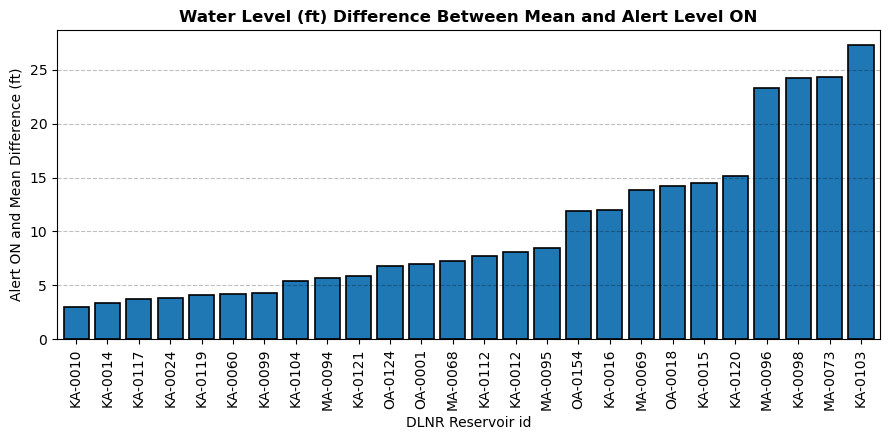

In [45]:
dlnrids = []
alert_mean_dif = [] 
Station_Meta = Station_Meta.set_index('properties.dlnrid')
stats_df = stats_df.set_index('dlrnid')
for i in stats_df.index:

    dlnrids.append(i)
    
    mean = stats_df['mean'][i]
    alert = Station_Meta['properties.level_alert_on'][i]
    difference = abs(alert - mean)
    
    alert_mean_dif.append(difference)


alert_mean_dic = {'dlrnid': dlnrids, 'alert_mean_difference': alert_mean_dif}
alert_mean_diff_df = pd.DataFrame(data=alert_mean_dic)
alert_mean_diff_df = alert_mean_diff_df.sort_values(by = ['alert_mean_difference']) 
alert_mean_diff_df = alert_mean_diff_df.dropna(how='any')

Station_Meta = Station_Meta.reset_index()
stats_df = stats_df.reset_index()

#data_info = result

#Create Barplot:
fig, ax = plt.subplots(figsize=(9, 4.5))


#bar graphs
rects = ax.bar(alert_mean_diff_df.dlrnid, alert_mean_diff_df.alert_mean_difference, edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.yticks(np.arange(0, 30, 5))



#the one year line
#a = ax.axhline(y = 1, color = 'r', linestyle = '-') 

#labels and margins
plt.title('Water Level (ft) Difference Between Mean and Alert Level ON', fontweight  = 'bold')
ax.set_xlabel('DLNR Reservoir id')
ax.set_ylabel('Alert ON and Mean Difference (ft)')


ax.margins(x=0.008, y=0.05)
plt.tight_layout()
plt.grid(color='black', which='major', axis='y', linestyle='dashed', alpha = 0.25)

plt.savefig(os.path.join(figures_path, 'difference_bw_alertON_and_mean.png'))

# Classifying Reservoirs using Alert Levels

In [46]:
def hydrologic_response_rating(WaterLevel_data, start_alert_WL, stop_alert_WL):
    
    hydrologic_response = 'unknown'

    #WL goes above the alert level = HAZARD
    for i in WaterLevel_data: 
        if i > start_alert_WL:
            hydrologic_response = 'HIGH'

    #WL never goes above alert level, but does go above the stop level = PROBLEM       
    if hydrologic_response  == 'unknown':
        for i in WaterLevel_data: 
            if i > stop_alert_WL:
                hydrologic_response  = 'MEDIUM'

    #WL never goes above the alert or stop levels = SAFE
    if hydrologic_response  == 'unknown':
        hydrologic_response = 'LOW'

    if math.isnan(start_alert_WL) == True: 
        hydrologic_response = 'NA'
    return hydrologic_response 

In [47]:
#determine station rating given alerts
hydrologic_response= {}

Station_Meta = Station_Meta.set_index('id')
for file in daily_WL_ommitted:
    
    #get the Water level alert levels from the SLC id in meta data table
    station_name = file #.split('.')[0].split('_')[1] #split the WL_..... file so that the SLC id is the only letters (remove WL_ and remove .csv)

    start_alert_WL = Station_Meta['properties.level_alert_on'][station_name] #start alert from meta data table
    stop_alert_WL = Station_Meta['properties.level_alert_off'][station_name] #stop alert from meta data table

    #create a list of Waterlevel data
    WaterLevel_data = daily_WL_ommitted[file]['data']

    #determine the station rating using function above
    station_rating = hydrologic_response_rating(WaterLevel_data, start_alert_WL, stop_alert_WL)
    
    #create a dictionary of hydrologic response ratings
    hydrologic_response[file] = station_rating

# create dataframe for hydrologic response to save as a table
data_info = data_info.set_index('Reservoir_station_file')

dlnrid = []
response_rating = []
for key in hydrologic_response:
    dlnrid.append(data_info['dlnrid'][key])
    response_rating.append(hydrologic_response[key])
    
hydrologic_response_dlnrid = pd.DataFrame({'dlnrid' : dlnrid, 'response_rating' : response_rating})
hydrologic_response_dlnrid.to_csv(os.path.join(tables_path, 'alert_level_response_ratings.csv'))

data_info = data_info.reset_index()
Station_Meta = Station_Meta.reset_index()

# Bar graph of Alert Classification of Reservoirs (ratings are based on # of alerts)

In [151]:
hydrologic_response

{'USGS_16094150': 'NA',
 'USGS_16206600': 'NA',
 'USGS_16208400': 'NA',
 'USGS_16210000': 'NA',
 'USGS_213133158014201': 'NA',
 'USGS_213308158035601': 'NA',
 'USGS_213320158061401': 'NA',
 'EDD00214': 'HIGH',
 'EDD00CC6': 'HIGH',
 'EDD01162': 'LOW',
 'EDD024F8': 'HIGH',
 'EDD02A2A': 'HIGH',
 'EDD0378E': 'MEDIUM',
 'EDD0395C': 'MEDIUM',
 'EDD0411E': 'LOW',
 'EDD04FCC': 'HIGH',
 'EDD05268': 'HIGH',
 'EDD05CBA': 'HIGH',
 'EDD067F2': 'HIGH',
 'EDD06920': 'HIGH',
 'EDD07484': 'HIGH',
 'EDD07A56': 'HIGH',
 'EDD08400': 'HIGH',
 'EDD08AD2': 'HIGH',
 'EDD099A4': 'LOW',
 'EDD0A2EC': 'HIGH',
 'EDD0AC3E': 'HIGH',
 'EDD0B19A': 'LOW',
 'EDD0BF48': 'HIGH',
 'EDD0C70A': 'HIGH',
 'EDD0C9D8': 'LOW',
 'EDD0D47C': 'LOW',
 'EDD0DAAE': 'MEDIUM'}

hazard: 17
problem: 3
safe: 6
unknown: 7


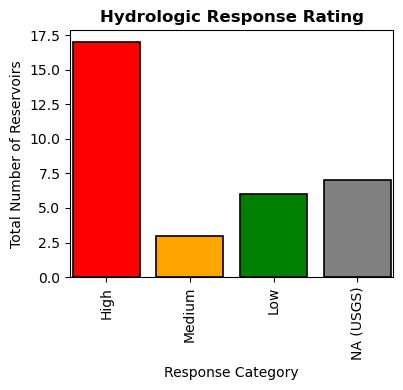

In [153]:
hazard = 0
problem = 0
safe = 0
unknown = 0

for file in hydrologic_response:
    if hydrologic_response[file] == 'HIGH':
        hazard += 1
    elif hydrologic_response[file] == 'MEDIUM':
        problem += 1
    elif hydrologic_response[file] == 'NA':
        unknown += 1
    else:
        safe += 1
        
        
print('hazard: ' + str(hazard))
print('problem: ' + str(problem))
print('safe: ' + str(safe))
print('unknown: ' + str(unknown))

#Create Barplot:
fig, ax = plt.subplots(figsize=(4, 4))

#bars
rects = ax.bar(['High', 'Medium', 'Low', 'NA (USGS)'], [hazard, problem, safe, unknown], color = ['red', 'orange', 'green', 'gray'], edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.bar

#labels
plt.title('Hydrologic Response Rating', fontweight  = 'bold')
ax.set_xlabel('Response Category')
ax.set_ylabel('Total Number of Reservoirs')

#margins and stuff
ax.margins(x=0.008, y=0.05)
plt.tight_layout()

plt.savefig(os.path.join(figures_path,'Reservoir_Classification_w_Alerts.png'))

# Find more details about the alerts: duration, start, end, highest water level, etc.

In [49]:
#create a list of Waterlevel data
#have to give it the waterlevel data dictionary, the file, and station_meta
def get_alert_info(Station_Meta, file, daily_WL_ommitted):
    WaterLevel_data = daily_WL_ommitted[file]
    WaterLevel_data = WaterLevel_data.reset_index()
    
    Station_Meta = Station_Meta.set_index('id')
    stop_alert_WL = Station_Meta['properties.level_alert_off'][file] #start alert from meta data table
    start_alert_WL = Station_Meta['properties.level_alert_on'][file] #stop alert from meta data table
    Station_Meta = Station_Meta.reset_index()

    #determine start alert dates


    WaterLevel_data['start_alert'] = np.nan
    # Ensure the column is of type object to hold strings
    WaterLevel_data['start_alert'] = WaterLevel_data['start_alert'].astype(object)
    
    for i in range(len(WaterLevel_data)):
        if WaterLevel_data.data[i] > start_alert_WL:
            WaterLevel_data.loc[i, 'start_alert'] = 'Y'
        else:
            # Use .loc[] to avoid chained assignment warning
            WaterLevel_data.loc[i, 'start_alert'] = 'N'
    #gather start date
    WaterLevel_data = WaterLevel_data.reset_index()
    start_date = []
    start_date_index = []
    for i in range(len(WaterLevel_data)):
        if i == 0 and WaterLevel_data.start_alert[i] == 'Y':
            start_date.append(WaterLevel_data.date[i])
            start_date_index.append(i)
        if i != 0:
            if WaterLevel_data.start_alert[i] == 'Y' and WaterLevel_data.start_alert[i-1] == 'N':
                start_date.append(WaterLevel_data.date[i]) 
                start_date_index.append(i)

    #gather end dates and event WL data
    end_date = []
    #Event_data = []
    for index in start_date_index:
        event_waterlevel_data = []
        event_waterlevel_data.append(WaterLevel_data.data[index])
        if index == (len(WaterLevel_data) - 1):
            event = 'end'
            end_date.append(WaterLevel_data.date[index])
        else:
            event = 'start'
        while event == 'start':
            if index == (len(WaterLevel_data) - 1):
                event = 'end'
                end_date.append(WaterLevel_data.date[index])
                break
            index += 1
            event_waterlevel_data.append(WaterLevel_data.data[index])
            if WaterLevel_data.data[index] < stop_alert_WL:
                event = 'end'
                end_date.append(WaterLevel_data.date[index])
                break
            if math.isnan(WaterLevel_data.data[index]) == True:
                event = 'end'
                end_date.append(WaterLevel_data.date[index])
                break
        #Event_data.append(event_waterlevel_data)
    
    duration = []
    for i in range(len(start_date)):
        duration.append(end_date[i] - start_date[i])

    #create a dataframe to merge all of the data into one
    df = pd.DataFrame.from_dict({'event_start': start_date , 'event_end': end_date, 'duration': duration})


    data = df
    grouped = data.groupby('event_end')
    event_start = []
    event_end = []
    event_duration = []
    for name, group in grouped:
        if len(group) > 1:
            group = group.sort_values(by = 'duration', ascending = False)
            group = group.reset_index()
            event_start.append(group.event_start[0])
            event_end.append(group.event_end[0])
            event_duration.append(group.duration[0])
        else:
            group = group.reset_index()
            event_start.append(group.event_start[0])
            event_end.append(group.event_end[0])
            event_duration.append(group.duration[0])
        
    df = pd.DataFrame.from_dict({'event_start': event_start , 'event_end': event_end, 'duration': event_duration})
    
    return df

In [50]:
WL_alerts= {}
for file in daily_WL_ommitted:
    WL_alerts[file] = get_alert_info(Station_Meta, file, daily_WL_ommitted)

# Bar graph of the total alerts occurring in each reservoir (UH SLC ONLY)

In [51]:
#create empty total alertscolumns
data_info['total_alerts'] = np.nan

#calculate total alerts in each reservoir
for i in range(0, len(data_info)):
    filename = data_info['Reservoir_station_file'][i]
    total_alerts = len(WL_alerts[filename])
    data_info.loc[i, 'total_alerts'] = total_alerts


#sort the reservoirs by highest alert and then pull only the ones that have an alert
data_info = data_info.sort_values(by = 'total_alerts')
hazard_only = data_info[data_info['total_alerts'] > 0]

hazard_only

Reservoir_station_file   end_date start_date  duration  completeness  \
21               EDD0C70A 2024-11-04 2021-10-11  3.068493      0.990187   
16               EDD08400 2024-11-04 2018-02-07  6.745205      0.194884   
15               EDD08AD2 2024-11-04 2019-03-21  5.630137      0.771401   
12               EDD05268 2024-11-04 2018-02-07  6.745205      0.745026   
9                EDD00214 2024-11-04 2018-02-07  6.745205      0.972797   
31               EDD024F8 2024-11-04 2018-02-07  6.745205      0.995534   
20               EDD0BF48 2024-08-27 2021-10-12  2.876712      0.992388   
5                EDD067F2 2024-11-04 2018-02-07  6.745205      0.895656   
3                EDD0AC3E 2024-11-04 2020-01-27  4.775342      0.998853   
2                EDD07484 2024-11-04 2018-02-07  6.745205      0.116525   
11               EDD04FCC 2024-11-04 2018-02-07  6.745205      0.922452   
13               EDD05CBA 2024-11-04 2018-02-07  6.745205      0.990662   
23               EDD0A2EC 2024-11-04 2019-11-07  4.997260      0.989041   
0                EDD00CC6 2024-11-04 2018-02-07  6.745205      0.375152   
25               EDD02A2A 2024-11-04 2018-02-07  6.745205      0.933821   
14               EDD06920 2024-11-04 2018-02-07  6.745205      0.361348   
8                EDD07A56 2024-11-04 2018-02-07  6.745205      0.952497   

     dlnrid  total_alerts  
21  MA-0095           1.0  
16  KA-0121           1.0  
15  KA-0120           1.0  
12  KA-0112           1.0  
9   KA-0099           1.0  
31  OA-0154           1.0  
20  MA-0094           2.0  
5   KA-0024           2.0  
3   KA-0015           2.0  
2   KA-0014           2.0  
11  KA-0104           5.0  
13  KA-0117           7.0  
23  OA-0001           8.0  
0   KA-0010           8.0  
25  OA-0018           9.0  
14  KA-0119          10.0  
8   KA-0098          12.0

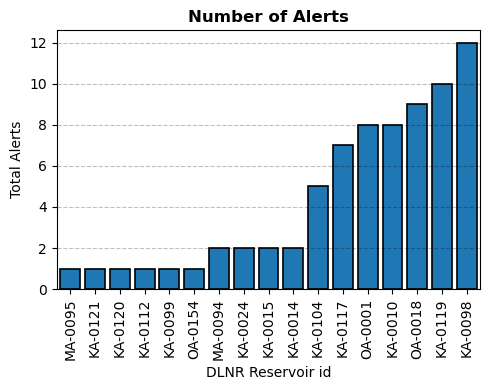

In [52]:
#Create Barplot:
fig, ax = plt.subplots(figsize=(5, 4))

#bars
rects = ax.bar(hazard_only.dlnrid, hazard_only['total_alerts'], edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.bar

#labels
plt.title('Number of Alerts', fontweight  = 'bold')
ax.set_xlabel('DLNR Reservoir id')
ax.set_ylabel('Total Alerts')

#margins and stuff
ax.margins(x=0.008, y=0.05)
plt.tight_layout()
plt.grid(color='black', which='major', axis='y', linestyle='dashed', alpha = 0.25)
plt.savefig(os.path.join(figures_path, 'Reservoir_AlertON_Count.png'))


# Dry seaon vs wet season total alerts (UH SLC ONLY)

In [53]:
dry = 0 #dry season alerts
wet = 0 #wet season alerts

alert_start_tally = [] # alert starting dates
alert_end_tally = []
duration_tally = [] # alert durations
reservoir = []
for file in WL_alerts:
    WL_alerts[file]['event_start'] = pd.to_datetime(WL_alerts[file].event_start)
    WL_alerts[file]['event_end'] = pd.to_datetime(WL_alerts[file].event_end)
    alert_months = WL_alerts[file].event_start.dt.month

    for month in range(len(alert_months)):
        alert_start_tally.append(WL_alerts[file]['event_start'][month])
        alert_end_tally.append(WL_alerts[file]['event_end'][month])
        duration_tally.append(WL_alerts[file]['duration'][month])
        reservoir.append(file)
        if month > 4 and month < 11:
            dry += 1
        else:
            wet += 1
            
            
print('total DRY season alerts: ' + str(dry))
print('total WET season alerts: ' + str(wet))

total DRY season alerts: 23
total WET season alerts: 50


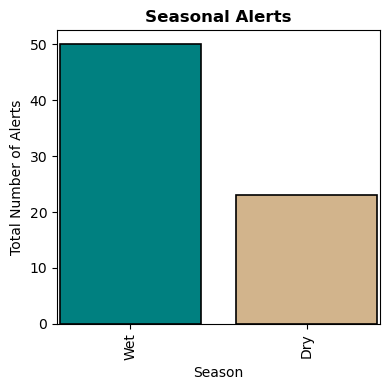

In [54]:
#Create Barplot:
fig, ax = plt.subplots(figsize=(4, 4))

#bars
rects = ax.bar(['Wet', 'Dry'], [wet,dry], color = ['teal', 'tan'], edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.bar

#labels
plt.title('Seasonal Alerts', fontweight  = 'bold')
ax.set_xlabel('Season')
ax.set_ylabel('Total Number of Alerts')

#margins and stuff
ax.margins(x=0.008, y=0.05)
plt.tight_layout()

plt.savefig(os.path.join(figures_path, 'BarGraph_seasonal_alert_count.png'))

# Alert Information Graphs: (duration, timing, location) & (duration, location, season) (UH SLC ONLY)

Collect all of the necessary data into a dataframe for the next few graphs

In [55]:

# Create dataframe to hold everything for graphs
alert_durations = pd.DataFrame()

# Must do weird python pandas things to get the number of days as an integer
alert_durations['duration'] = duration_tally
alert_durations['duration'] = alert_durations['duration'].dt.days.astype('int16')

# Create a column of alert starting time and ending
alert_durations['alert_start'] = alert_start_tally
alert_durations['alert_end'] = alert_end_tally

# Create a column of reservoir name that the alert occurred in
alert_durations['reservoir'] = reservoir

# Create a column for the state that the alert occurred in
# Initialize the 'dlnrid' and 'state' columns as object type to hold string values
alert_durations['dlnrid'] = pd.Series(dtype='object')
alert_durations['state'] = pd.Series(dtype='object')

for i in range(len(alert_durations)):
    file = alert_durations.loc[i, 'reservoir']
    SLC_id = file  # .split('.')[0].split('_')[1] if you need to extract specific parts
    station_meta_index = np.where(Station_Meta.id == SLC_id)[0][0]
    dlnrid = Station_Meta.loc[station_meta_index, 'properties.dlnrid']
    alert_durations.loc[i, 'dlnrid'] = dlnrid
    
    # Determine the state based on the dlnrid value
    if alert_durations.loc[i, 'dlnrid'].split('-')[0] == 'KA':
        alert_durations.loc[i, 'state'] = 1
    elif alert_durations.loc[i, 'dlnrid'].split('-')[0] == 'OA':
        alert_durations.loc[i, 'state'] = 2
    elif alert_durations.loc[i, 'dlnrid'].split('-')[0] == 'MA':
        alert_durations.loc[i, 'state'] = 3

# Create a column of the month that the alert occurred in using the starting date
alert_durations['month'] = alert_durations['alert_start'].dt.month

### Graph of Alert Duration, Timing, Location (UH SLC ONLY)

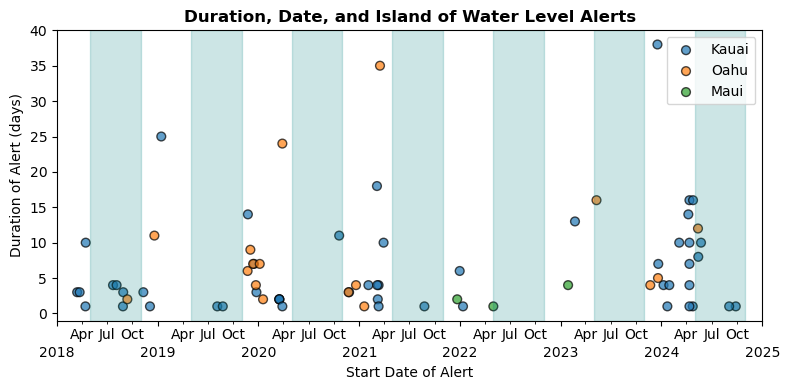

In [56]:
#plot every alert through spatial timing of the alerts, duration, and location
KA_alerts = alert_durations.loc[alert_durations['state'] == 1.0] #state 
OA_alerts = alert_durations.loc[alert_durations['state'] == 2.0]
MA_alerts = alert_durations.loc[alert_durations['state'] == 3.0]

#get the rainy seasons
start_rain = np.datetime64('2017-11-01')
# Use pd.DateOffset to add 6 months
rain_season_start_end = {}

start = []
end = []
total_rounds = (datetime.now().year - (start_rain.astype('datetime64[Y]').astype(int) + 1970) ) * 2
for i in range(total_rounds):
    season_change = (i + 1)
    if season_change % 2 == 0:
        start.append(pd.Timestamp(start_rain) + pd.DateOffset(months=6 * season_change))
    else:
        end.append(pd.Timestamp(start_rain) + pd.DateOffset(months=6 * season_change))
rain_season_start_end['start'] = start
rain_season_start_end['end'] = end

#plot every alert through spatial timing of the alerts, duration, and location

#group by state
groups = alert_durations.groupby('state')

fig, ax = plt.subplots(figsize=(8,4))

#color the dots by state and plot as a scatter
for name, group in groups:
    ax.scatter(group["alert_start"], group["duration"], marker="o", linestyle="", label=name, alpha = 0.7, s = 40, edgecolor = 'k')

for i in range(len(rain_season_start_end['start'])):
    ax.axvspan(rain_season_start_end['start'][i],rain_season_start_end['end'][i], alpha=0.2, color='teal')
#labels
ax.set_title('Duration, Date, and Island of Water Level Alerts', fontweight = 'bold')
ax.set_ylabel('Duration of Alert (days)')
ax.set_xlabel('Start Date of Alert')

#x axis lables and what not
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator()) #year locator
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((4,7,10))) #only months apr, jul, oct
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y")) 
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
plt.gca().set_xbound(pd.to_datetime('01-01-2018'), pd.to_datetime('01-01-2025')) #x axis limit
ax.set_ylim(-1, 40) #y axis limit
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")


#Legend
ax.legend(['Kauai', 'Oahu', 'Maui'])

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'WLAlerts_Durations_for_each_Island.png'))

## Plot the Alerts Timeline for each reservoir

In [57]:
result = result.reset_index()
data_info = data_info.reset_index()

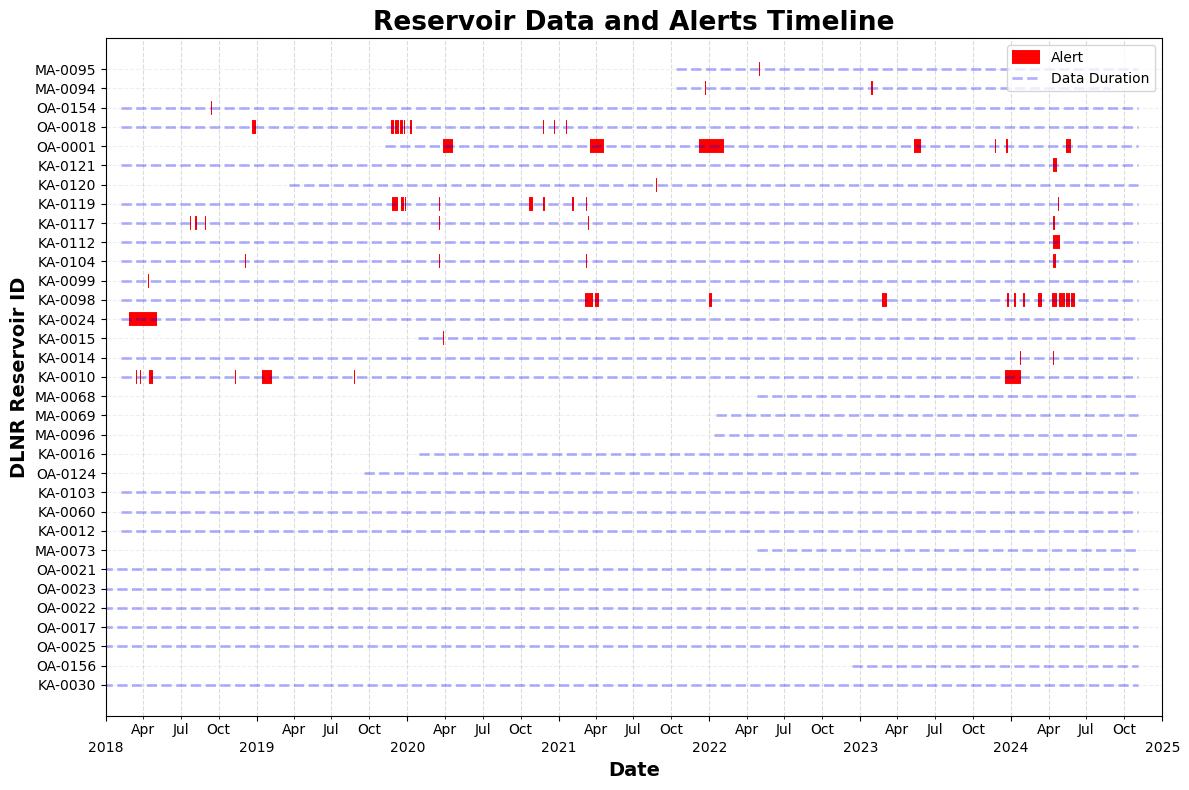

In [58]:

fig, ax = plt.subplots(figsize=(12,8))
data_info = data_info.set_index('dlnrid')


#plot timeseries of non alerts
reservoirs_w_alerts = []    
#get a list of all reservoirs with alerts
reservoirs_w_alerts.append(KA_alerts.dlnrid.unique().tolist())
reservoirs_w_alerts.append(OA_alerts.dlnrid.unique().tolist())
reservoirs_w_alerts.append(MA_alerts.dlnrid.unique().tolist())
reservoirs_w_alerts = list((itertools.chain.from_iterable(reservoirs_w_alerts)))

result = result.set_index('dlnrid')
for i in result.index:
    if i in reservoirs_w_alerts:
        continue
    else: 
        ax.hlines(y= i, xmin = result.start_date[i], xmax = result.end_date[i], alpha = 0.3, linestyle = '--', color = 'blue', lw = 2)
result = result.reset_index() 



#plot the timelines by state...
groups = KA_alerts.groupby(['dlnrid'])
for name, group in groups:
    ax.hlines(y= group['dlnrid'], xmin = group["alert_start"], xmax = group["alert_end"], colors = 'r', lw = 10)
    #plot start and end of data
    dlnrid = group['dlnrid'].reset_index(drop = True)[0]
    ax.hlines(y= dlnrid, xmin = data_info.start_date[dlnrid], xmax = data_info.end_date[dlnrid], alpha = 0.3, linestyle = '--', color = 'blue', lw = 2)
groups = OA_alerts.groupby(['dlnrid'])
for name, group in groups:
    ax.hlines(y= group['dlnrid'], xmin = group["alert_start"], xmax = group["alert_end"], colors = 'r', lw = 10)
        #plot start and end of data
    dlnrid = group['dlnrid'].reset_index(drop = True)[0]
    ax.hlines(y= dlnrid, xmin = data_info.start_date[dlnrid], xmax = data_info.end_date[dlnrid], alpha = 0.3, linestyle = '--', color = 'blue', lw = 2)
groups = MA_alerts.groupby(['dlnrid'])
for name, group in groups:
    a = ax.hlines(y= group['dlnrid'], xmin = group["alert_start"], xmax = group["alert_end"], colors = 'r', lw = 10)
    #plot start and end of data
    dlnrid = group['dlnrid'].reset_index(drop = True)[0]
    b = ax.hlines(y= dlnrid, xmin = data_info.start_date[dlnrid], xmax = data_info.end_date[dlnrid], alpha = 0.3, linestyle = '--', color = 'blue', lw = 2)






#### plot  the x axis date format stuff
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((4,7,10)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize = 10)
plt.gca().set_xbound(pd.to_datetime('01-01-2018'), pd.to_datetime('01-01-2025')) # Changes x-axis range


#title and axis labels
ax.set_title('Reservoir Data and Alerts Timeline', fontweight = 'bold', fontsize = 19)
ax.set_ylabel('DLNR Reservoir ID', weight = 'bold', fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)

#Legend
ax.legend([a,b], ['Alert', 'Data Duration'])

#plot the dash lines 
a = plt.grid(alpha = 0.45, linestyle = '--', which =  'both', axis = 'x')
b = plt.grid(alpha = 0.2, linestyle = '--', which =  'both', axis = 'y')
#b = plt.grid(alpha = 0.14, linestyle = '--', color = 'r', axis = 'y', lw = '2')



plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'WL_Alert_timeline.png'))

data_info = data_info.reset_index()

### Graph showing Alert Duration, Location, Season (UH SLC ONLY)

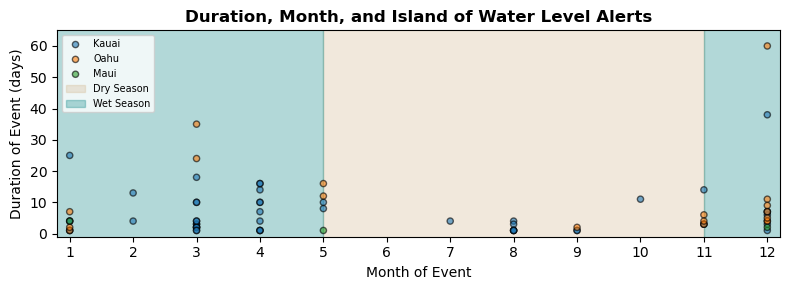

In [59]:
#plot every alert through spatial timing of the alerts, duration, and location
KA_alerts = alert_durations.loc[alert_durations['state'] == 1.0]
OA_alerts = alert_durations.loc[alert_durations['state'] == 2.0]
MA_alerts = alert_durations.loc[alert_durations['state'] == 3.0]

#plot the points of alerts
fig, ax = plt.subplots(figsize=(8,3))
a = ax.scatter(KA_alerts["month"], KA_alerts["duration"], marker="o", linestyle="", alpha = 0.6, s = 20, edgecolor = 'k')
b = ax.scatter(OA_alerts["month"], OA_alerts["duration"], marker="o", linestyle="", alpha = 0.6, s = 20, edgecolor = 'k')
c = ax.scatter(MA_alerts["month"], MA_alerts["duration"], marker="o", linestyle="", alpha = 0.6, s = 20, edgecolor = 'k')

#labels
ax.set_title('Duration, Month, and Island of Water Level Alerts', fontweight = 'bold')
ax.set_ylim(-1, 65)
ax.set_xlim(0.8, 12.2)
ax.set_ylabel('Duration of Event (days)')
ax.set_xlabel('Month of Event')


ax.fill_between([5,6,7,8,9,11], -10, 80, color = 'tan', alpha = 0.3, zorder = 0) #dry season color
ax.fill_between([0,1,2,3,4, 5], -10, 80, color = 'teal', alpha = 0.3, zorder = 0) #wet season color
ax.fill_between([11, 11,12, 13], -10, 80, color = 'teal', alpha = 0.3, zorder = 0) #wet season color
ax.legend(['Kauai', 'Oahu', 'Maui', 'Dry Season', 'Wet Season'], fontsize = 7, loc= 'upper left') #legend
plt.xticks([*range(1,13)])

plt.tight_layout()


# Calculate Daily Slope Trends

Calculate the slopes using linear trends. Figure out the linear trend of the slope and the length of the slope in days. The next day must be a reversal for a new slope to be calculated. If the next day is at the same water level, continue calculating the same trend slope. Once the trend is reversed, the first and last point will be used to figure out the linear trend.

In [60]:
import pandas as pd
import numpy as np

def get_slopes(WL_data, date):
    all_slopes = []
    start = []
    end = []
    all_total_n = []
    flexible_range = 0  # Flexible range on linear trend

    i = 0
    while i < (len(WL_data) - 1):
        tally = []  # For appending WL data that follows a consistent up or down trend

        if pd.notna(WL_data.iloc[i]):
            if pd.notna(WL_data.iloc[i + 1]):  # Check for NaN
                # Water level is going up
                if WL_data.iloc[i + 1] >= (WL_data.iloc[i] + flexible_range):
                    start.append(date[i])  # Directly access date
                    j = WL_data.iloc[i + 1]
                    starting_WL = WL_data.iloc[i]
                    tally.append(starting_WL)  # Start tallying WL data in trend
                    while (j + flexible_range) >= starting_WL:
                        if i <= (len(WL_data) - 2):  # Ensure within bounds
                            if pd.notna(WL_data.iloc[i + 1]):  # Must not be NaN
                                j = WL_data.iloc[i + 1]
                                starting_WL = WL_data.iloc[i]
                                tally.append(j)  # Keep track of the data trend
                                i += 1  # Move to the next value in WL data
                            else:
                                break  # Exit if the trend breaks
                        else:
                            break  # If at the end of data, close the loop
                    tally.pop()  # Remove last item where trend was broken
                    total_n = len(tally)  # Total number of data samples in trend
                    all_total_n.append(total_n)  # List of all total samples

                    slope = (tally[-1] - tally[0]) / total_n  # Calculate slope
                    all_slopes.append(slope)  # Keep track of all slopes
                    end.append(date[i])  # Directly access date
                    continue

                # Water level is going down
                if WL_data.iloc[i + 1] < (WL_data.iloc[i] + flexible_range):
                    start.append(date[i])  # Directly access date
                    j = WL_data.iloc[i + 1]
                    starting_WL = WL_data.iloc[i]
                    tally.append(starting_WL)
                    while (j - flexible_range) <= starting_WL:
                        if i <= (len(WL_data) - 2):
                            if pd.notna(WL_data.iloc[i + 1]):
                                j = WL_data.iloc[i + 1]
                                starting_WL = WL_data.iloc[i]
                                tally.append(j)
                                i += 1
                            else:
                                break
                        else:
                            break
                    tally.pop()  # Remove last item where trend was broken
                    total_n = len(tally)
                    all_total_n.append(total_n)
                    slope = (tally[-1] - tally[0]) / total_n
                    all_slopes.append(slope)
                    end.append(date[i])  # Directly access date
                    continue

            i += 1  # Move to next value
        else:
            i += 1

    # Create a DataFrame of everything    
    slopes_df = pd.DataFrame({
        'n_data': all_total_n,
        'avg_WL_change_per_n': all_slopes,
        'start': start,
        'end': end
    })

    # Assigning direction of the slopes using np.where to avoid chained assignment warning
    slopes_df['neg_pos'] = np.where(slopes_df['avg_WL_change_per_n'] > 0, 1,
                                     np.where(slopes_df['avg_WL_change_per_n'] < 0, -1, np.nan))

    return slopes_df


In [61]:
#use the function above to get all of the slopes for each reservoir water level data
Reservoir_Slopes = {}
for key in daily_WL_ommitted:
    Reservoir_Slopes[key] = get_slopes(daily_WL_ommitted[key]['data'], daily_WL_ommitted[key].index)


## Visualizing the slope data before and after normalization using hydraulic height

BEFORE standardization

USGS_16094150
USGS_16206600
USGS_16208400
USGS_16210000
USGS_213133158014201
USGS_213308158035601
USGS_213320158061401
EDD00214
EDD00CC6
EDD01162
EDD024F8
EDD02A2A
EDD0378E
EDD0395C
EDD0411E
EDD04FCC
EDD05268
EDD05CBA
EDD067F2
EDD06920
EDD07484


C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\2911717988.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,3))


EDD07A56
EDD08400
EDD08AD2
EDD099A4
EDD0A2EC
EDD0AC3E
EDD0B19A
EDD0BF48
EDD0C70A
EDD0C9D8
EDD0D47C
EDD0DAAE


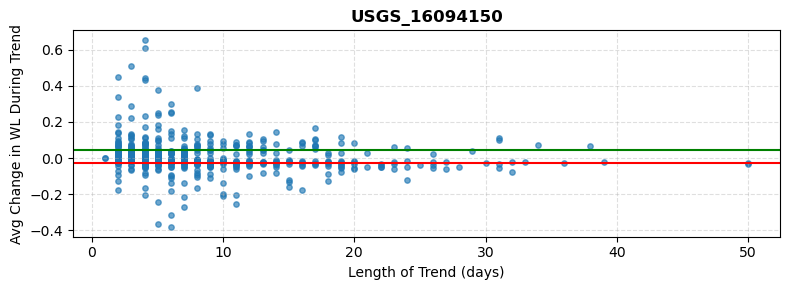

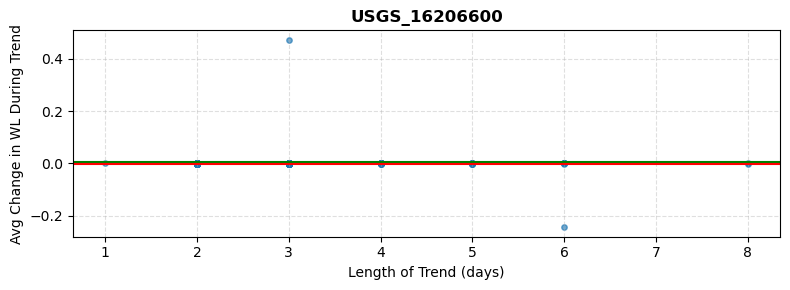

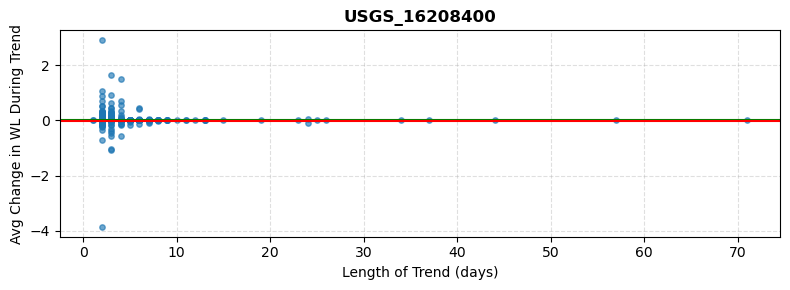

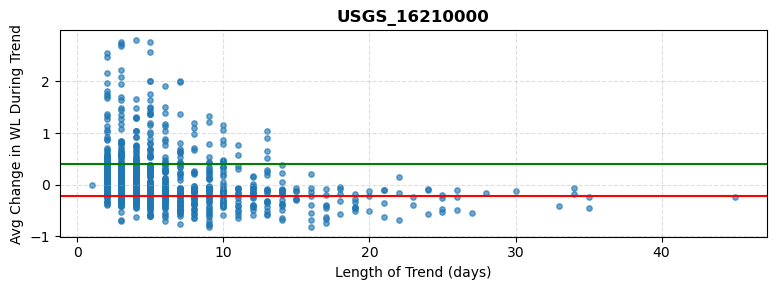

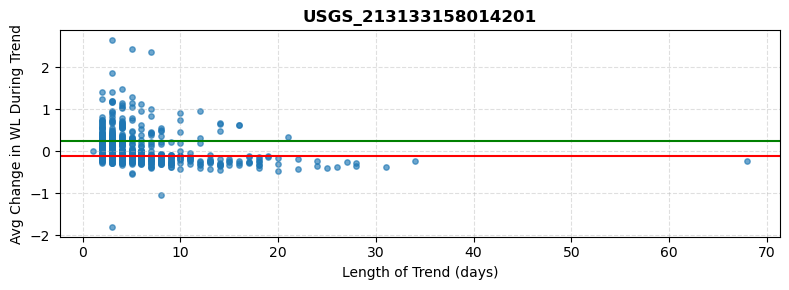

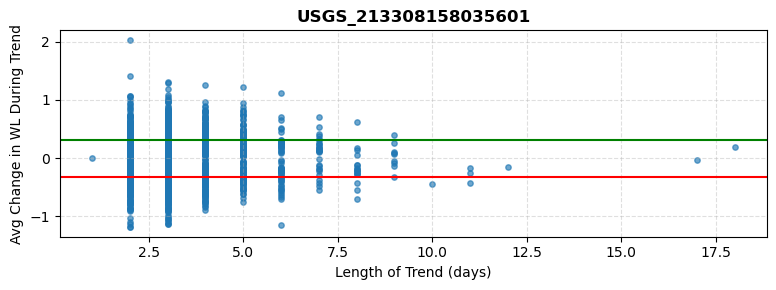

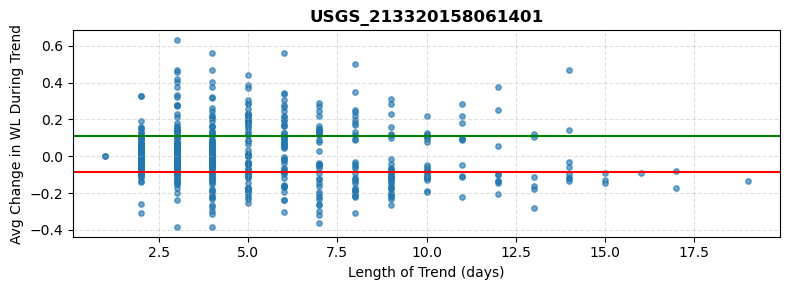

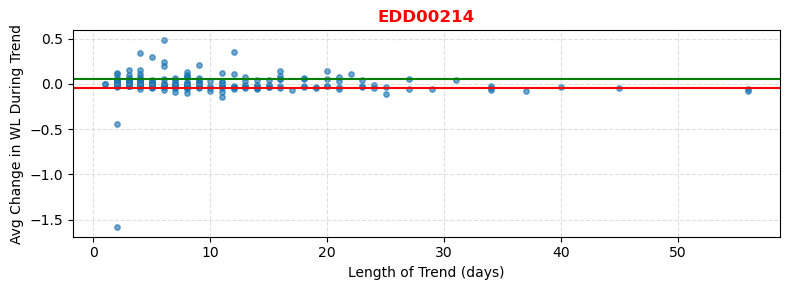

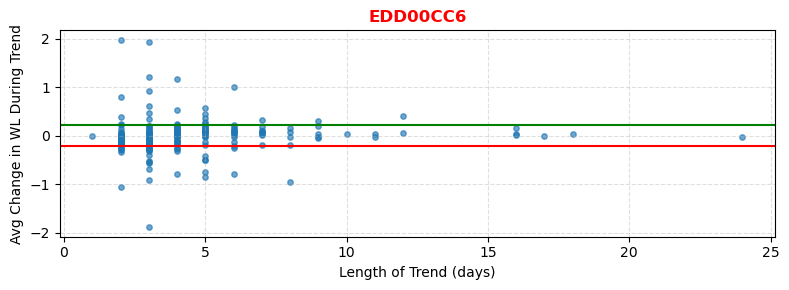

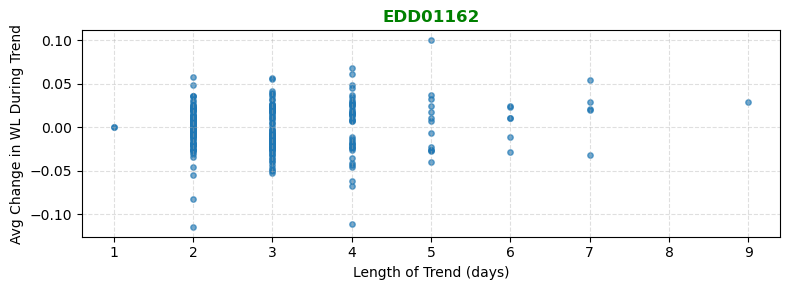

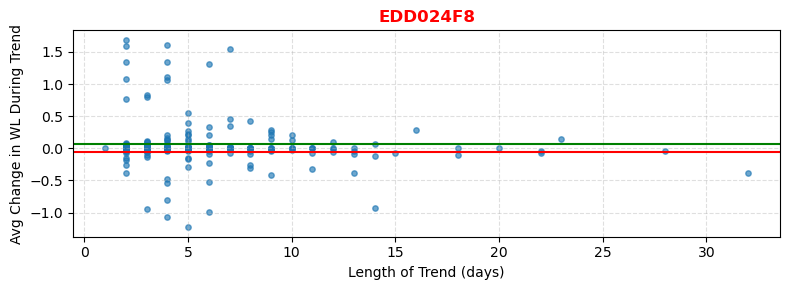

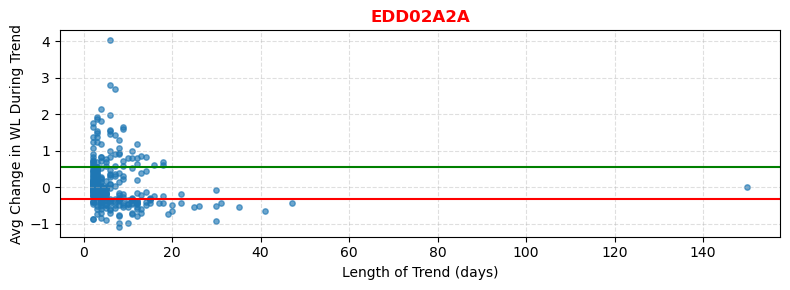

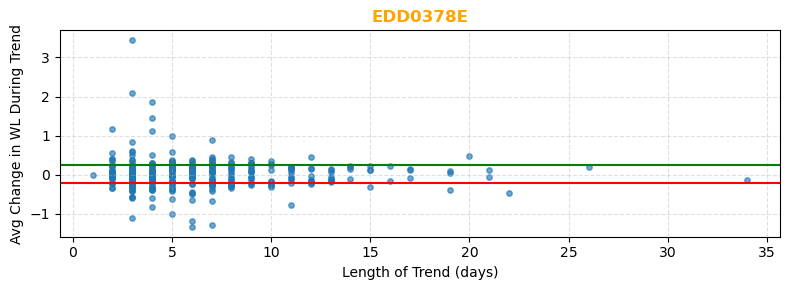

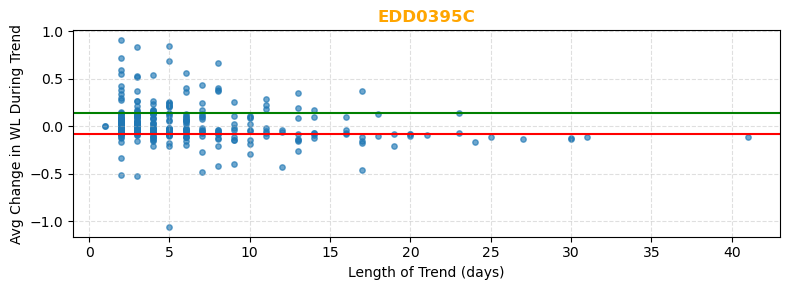

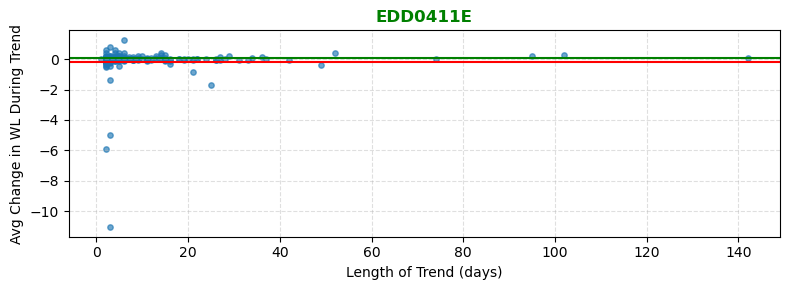

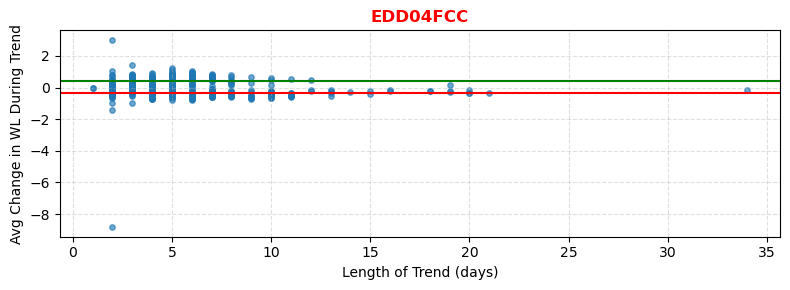

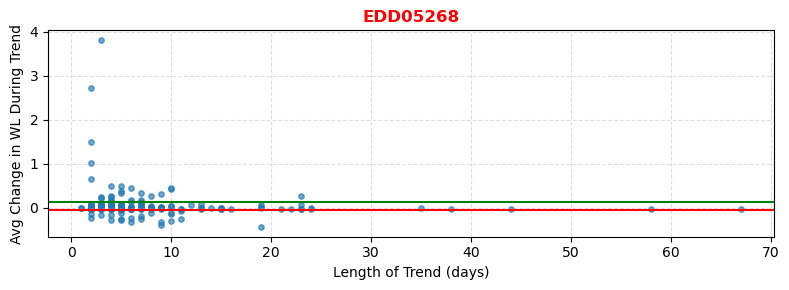

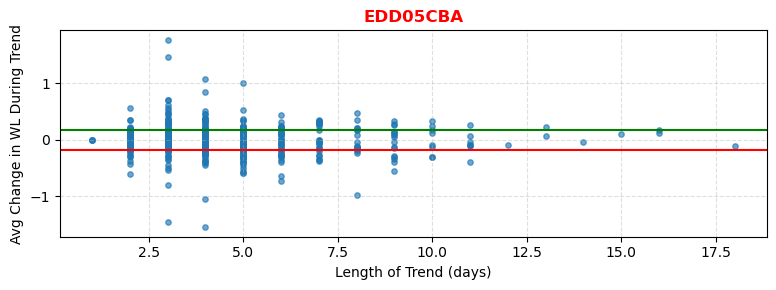

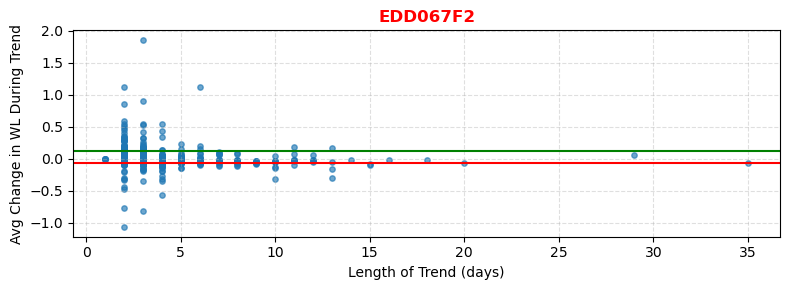

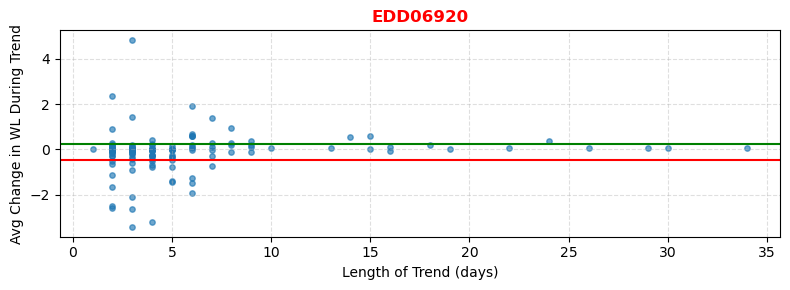

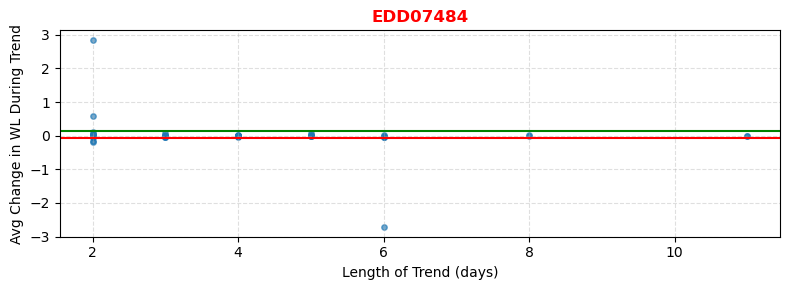

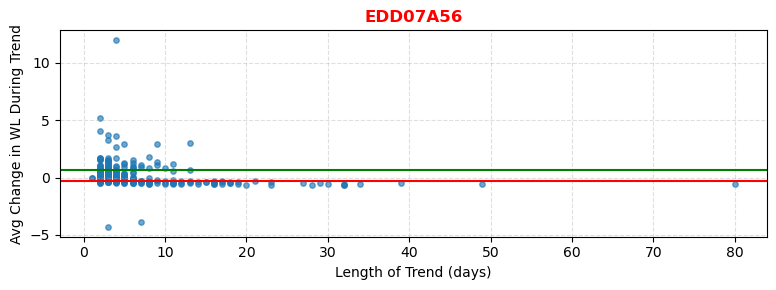

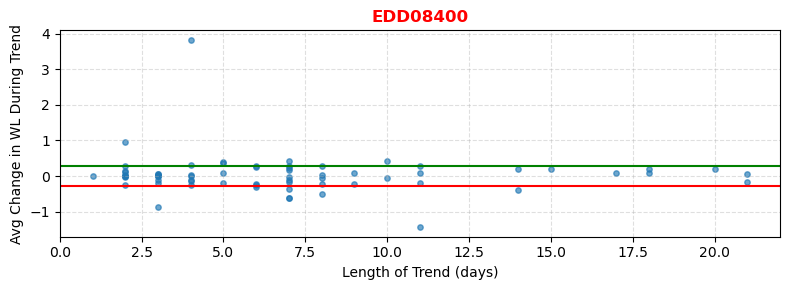

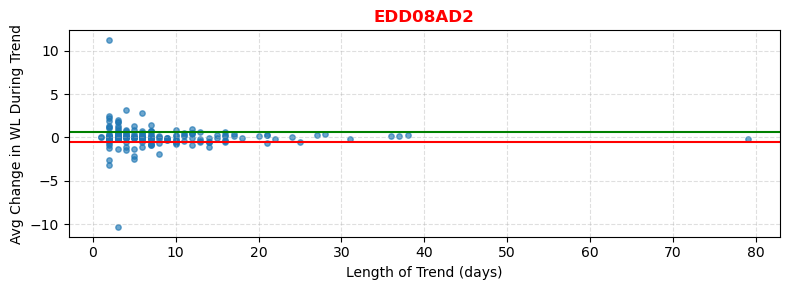

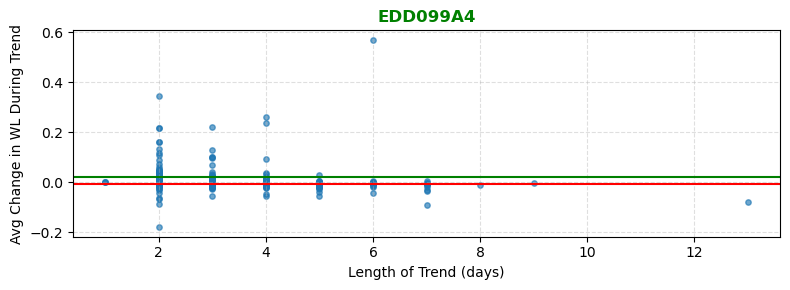

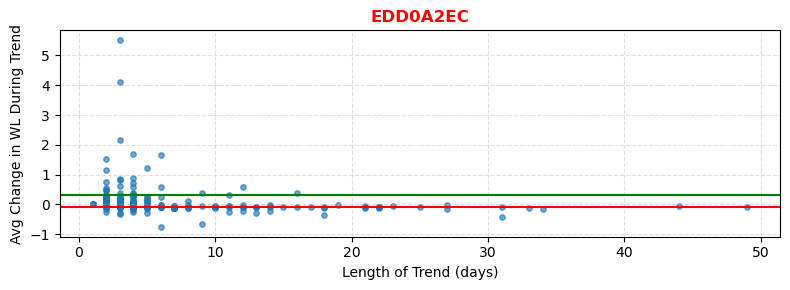

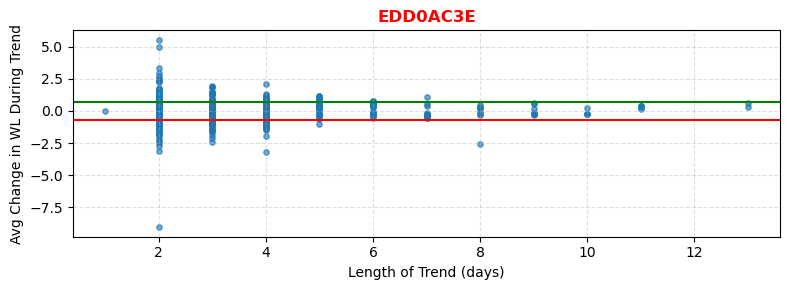

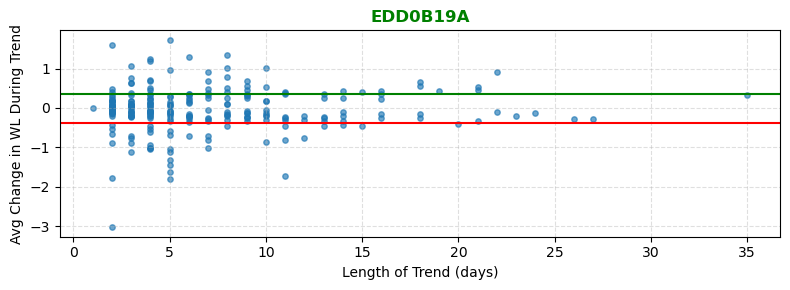

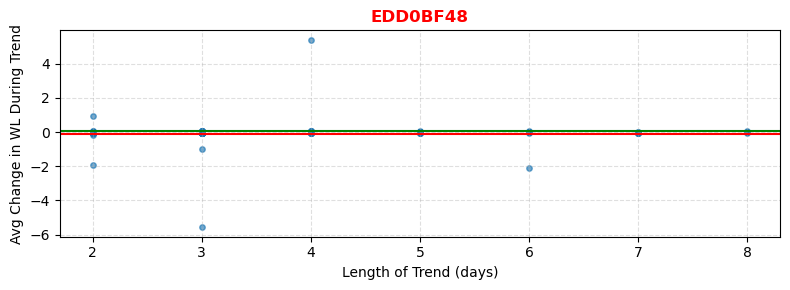

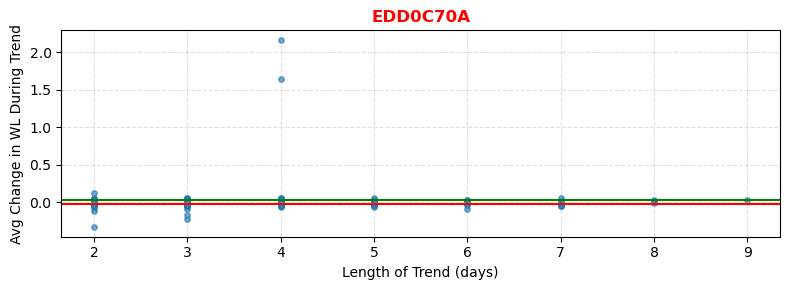

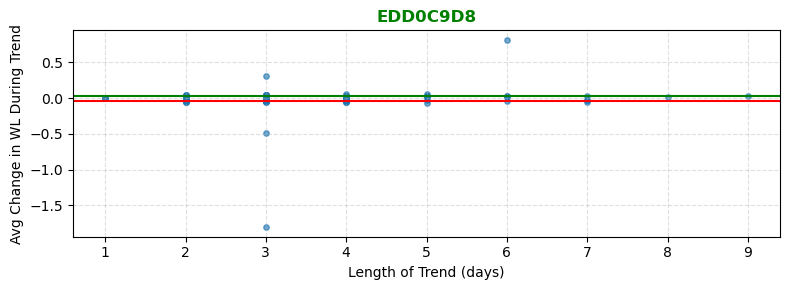

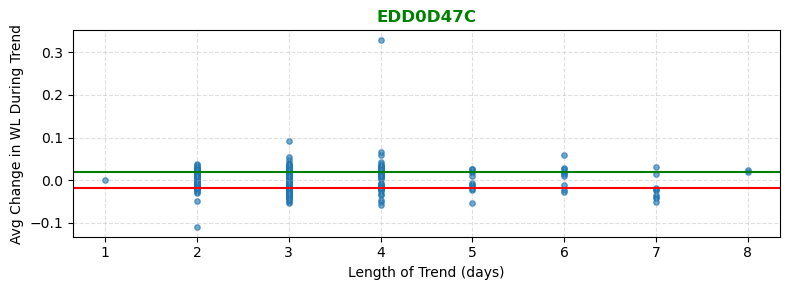

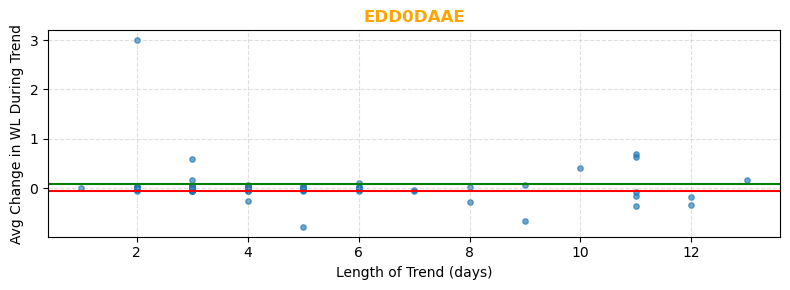

In [62]:
#plot the slope points using the average linear trend and the length of the trend recorded
#color the titles based on the hdyrologic response rating determined using the alert levels
colors={'HIGH' : 'red', 'MEDIUM' : 'orange', 'LOW' : 'green', 'NA' : 'black'} 

for key in Reservoir_Slopes:
    print(key)
    h_response = hydrologic_response[key]
    c = colors[h_response]
    
    fig, ax = plt.subplots(figsize=(8,3))
    
    #plot scatter
    ax.scatter(Reservoir_Slopes[key]['n_data'], Reservoir_Slopes[key]['avg_WL_change_per_n'], s= 15, alpha = 0.65)
    
    if key != 'EDD01162' and key != 'EDD11398': #these reservoirs don't have enough data for means
        #determine mean positive and mean negative trends
        avgUPtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['avg_WL_change_per_n'].mean().tolist()[1]
        avgDOWNtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['avg_WL_change_per_n'].mean().tolist()[0]
        #plot the trends as horizontal line
        plt.axhline(y = avgUPtrend, color = 'g', linestyle = '-')
        plt.axhline(y = avgDOWNtrend, color = 'r', linestyle = '-')
        
    #labels
    ax.set_title(key, color = c, fontweight = 'bold')
    ax.set_xlabel('Length of Trend (days)')
    ax.set_ylabel('Avg Change in WL During Trend')
    
    #grid to make it look nicer
    a = plt.grid(alpha = 0.4, linestyle = '--', which =  'both')
    plt.tight_layout()

Standardize THE SLOPES:
normalize the change in WL trends by the hydraulic height. Change it to percentages... How much does the WL change relative to the maximum hydraulic height. It will be normalized to percentages: If the hydraulic height is 10 ft and the trend is +1ft/day, then the % change is 10%

C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\3084033986.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,3))


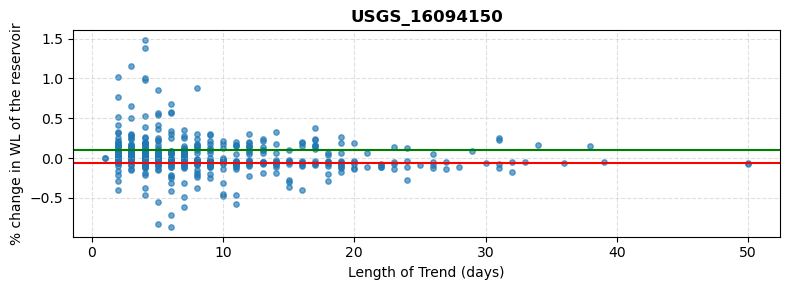

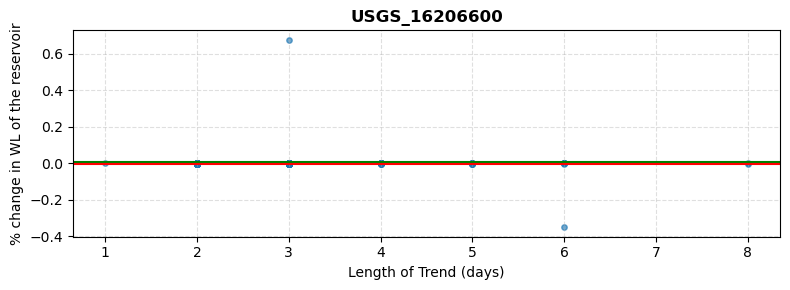

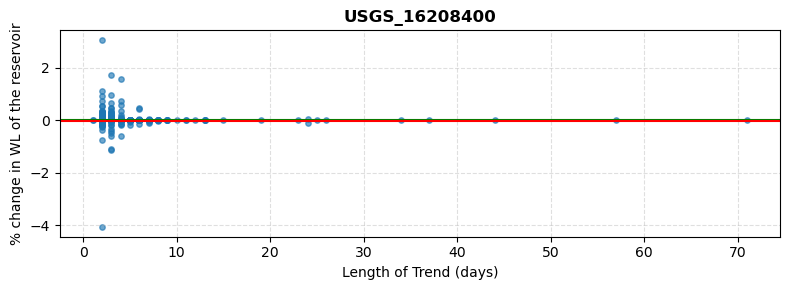

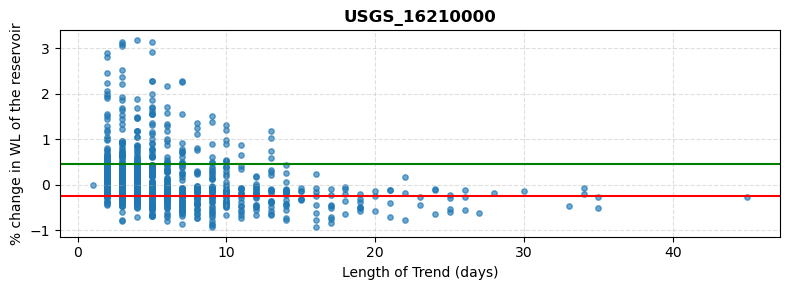

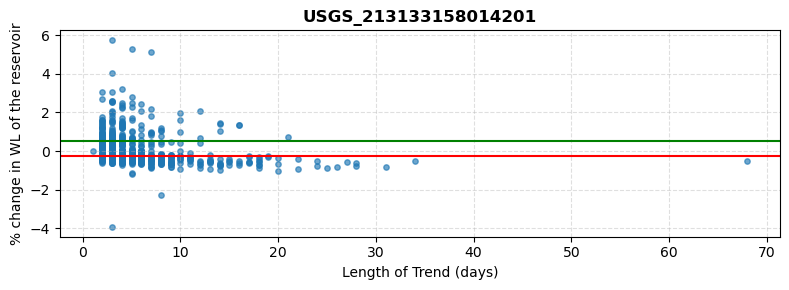

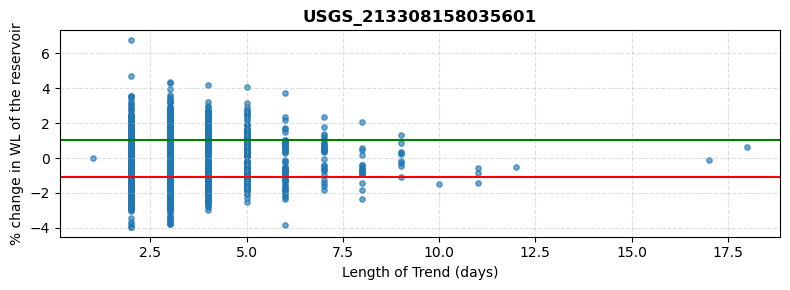

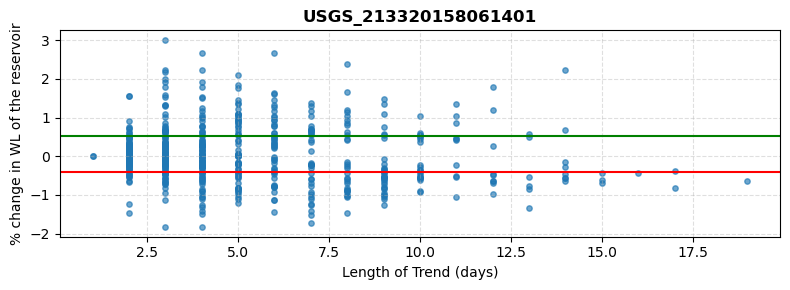

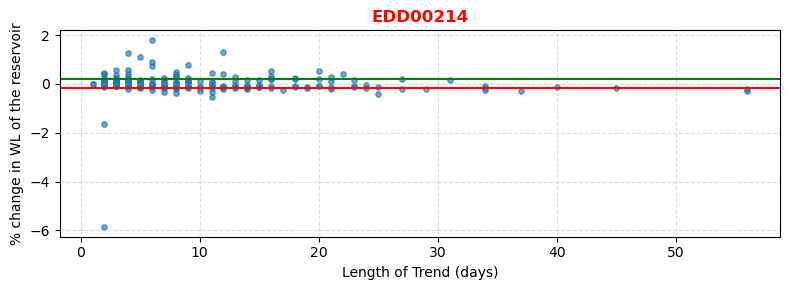

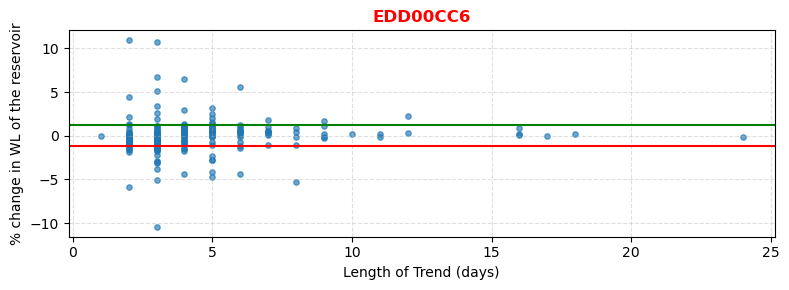

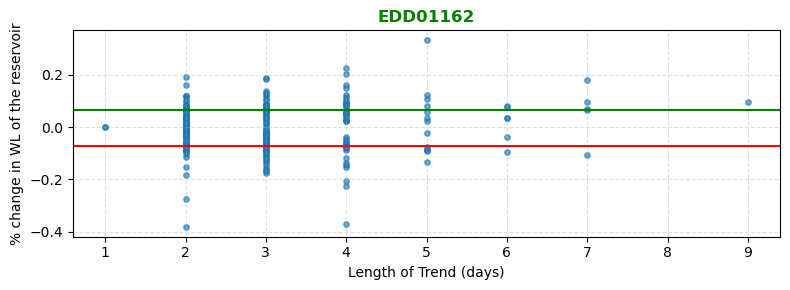

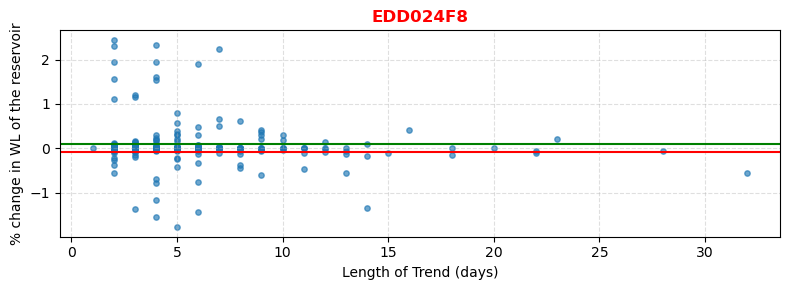

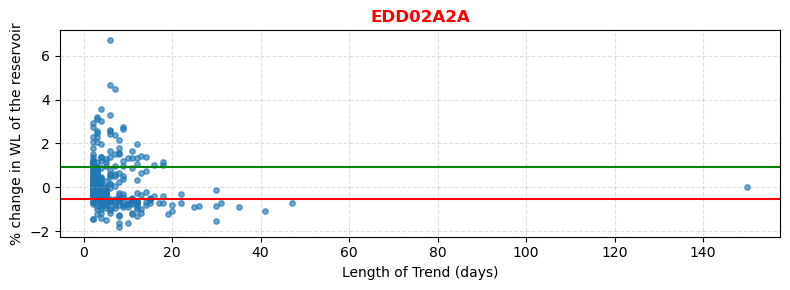

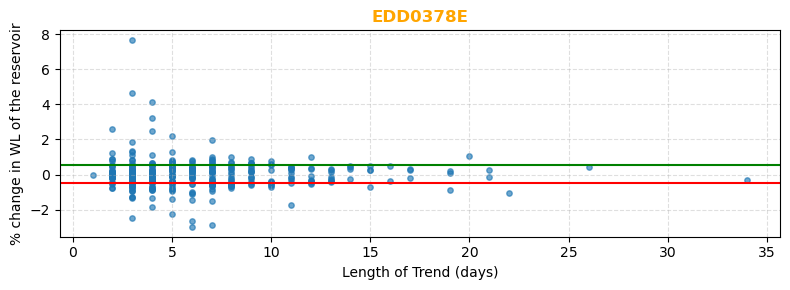

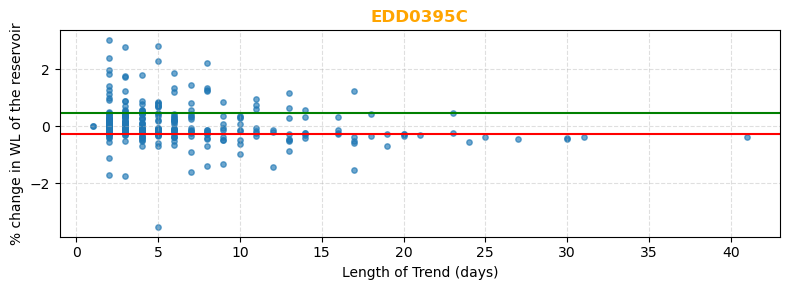

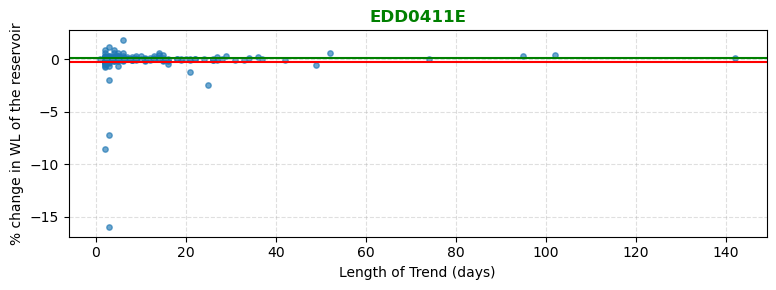

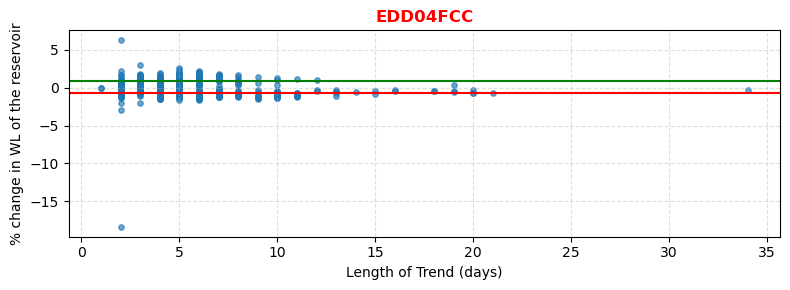

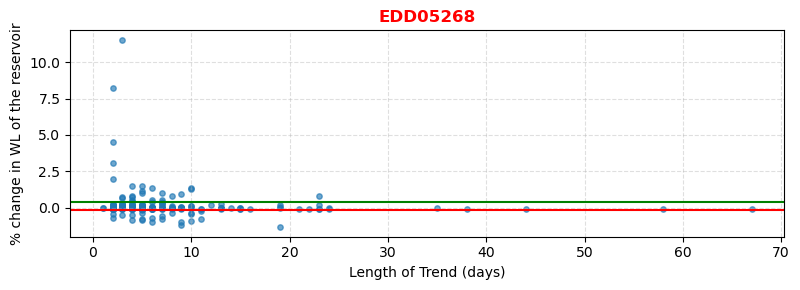

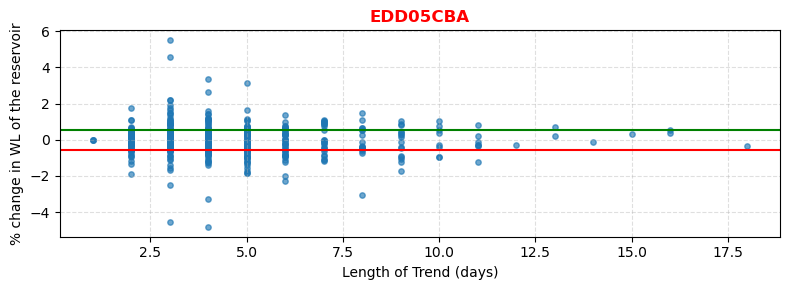

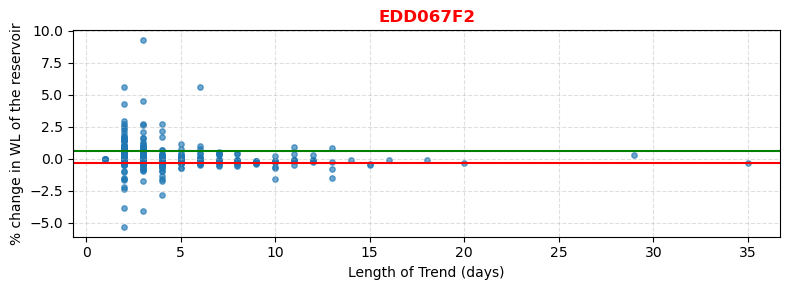

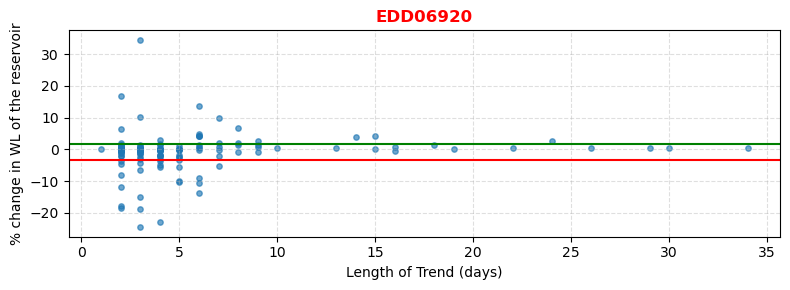

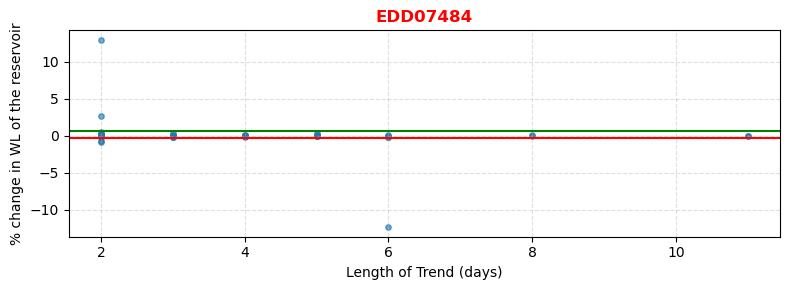

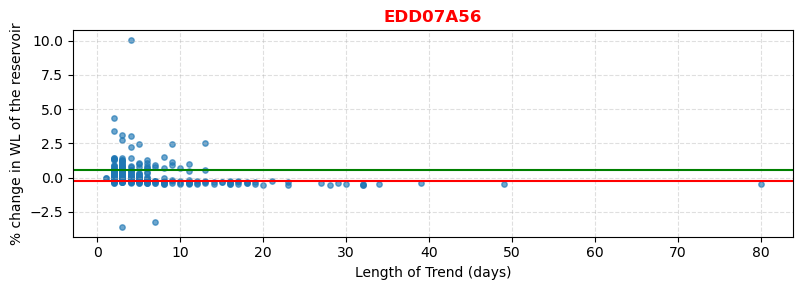

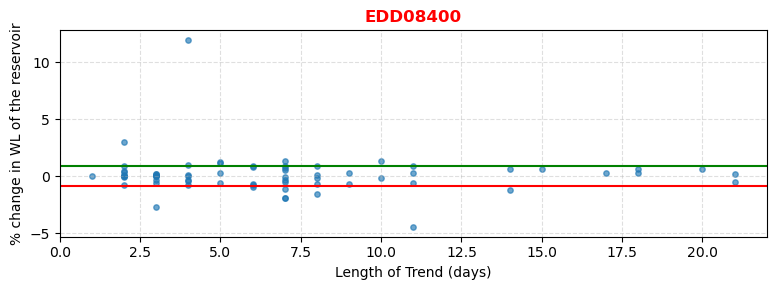

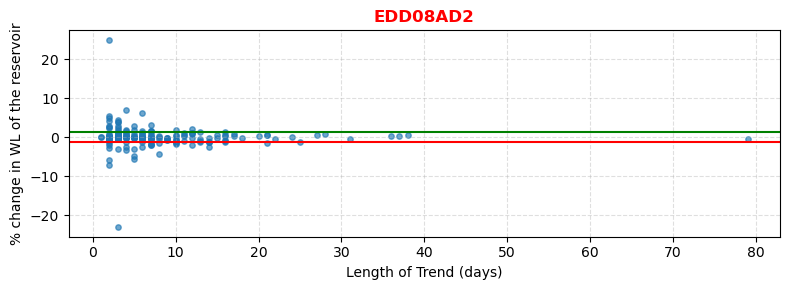

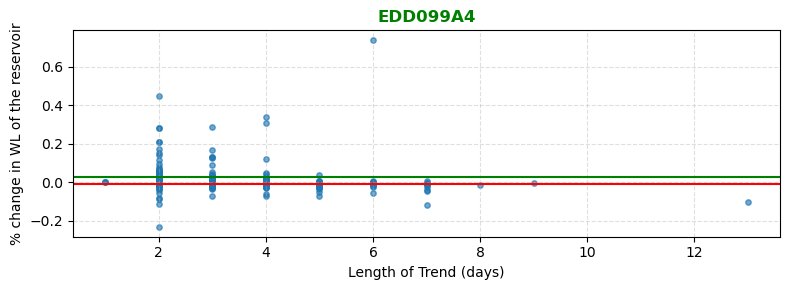

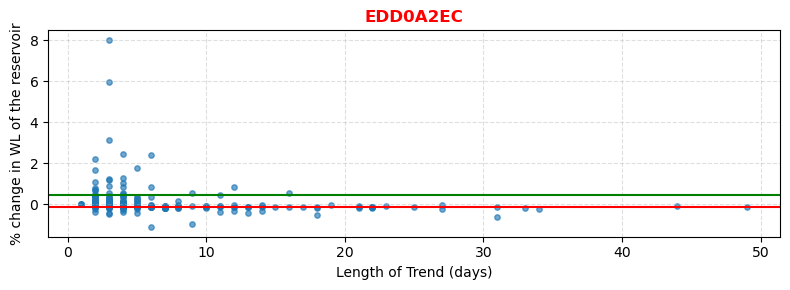

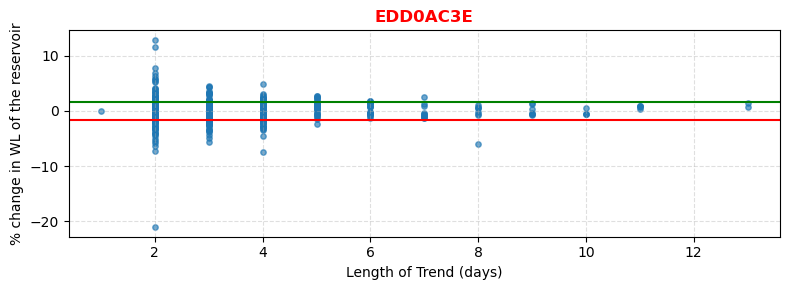

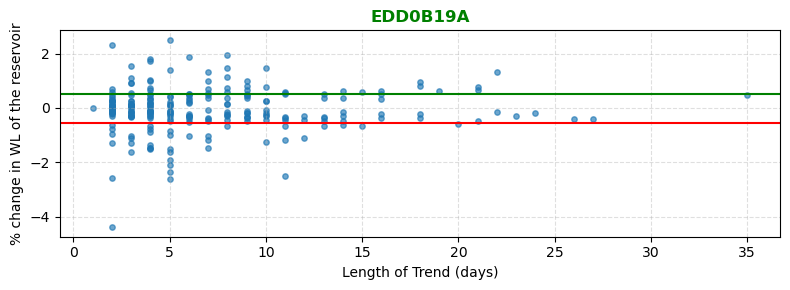

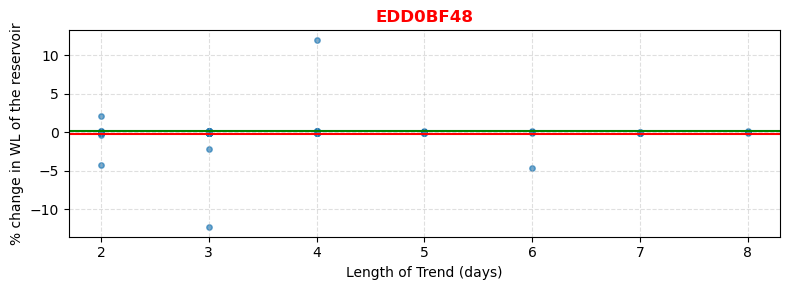

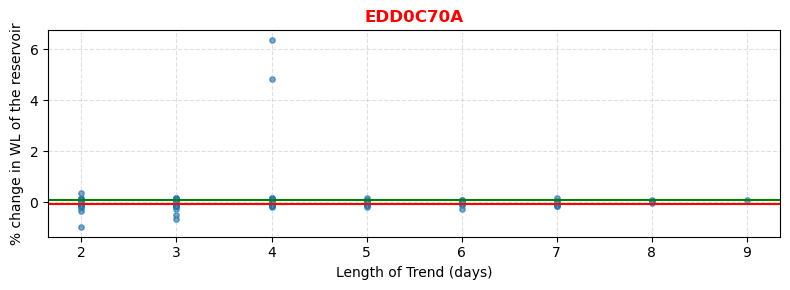

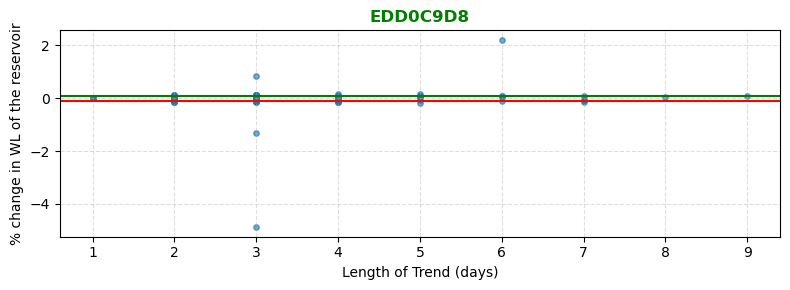

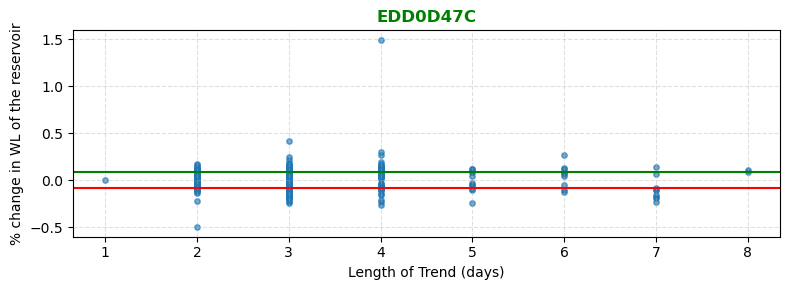

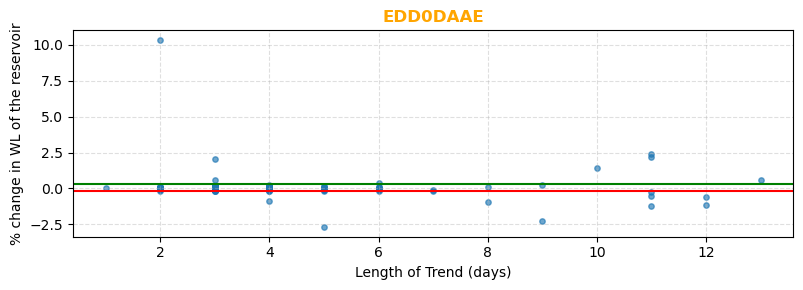

In [63]:
#normalize the slope trend data using the hydraulic heights
hydr_height = pd.read_csv(os.path.join("..", "Data/Basin_dam_website_data", '071723ForKoa_ResCordsData_editted2.csv'))
for key in Reservoir_Slopes:
    res_id = key.replace('WL_', '').replace('.csv', '') #get the Id without the file name .csv
    if res_id in hydr_height.RES_ID.tolist():
        reservoir_index = hydr_height.index[hydr_height['RES_ID']==res_id].tolist()[0]
        hydraulic_height_val = hydr_height['Hydraulic_Height-ft'][reservoir_index]
        Reservoir_Slopes[key]['normalized_change_WL'] = ( Reservoir_Slopes[key]['avg_WL_change_per_n'] / hydraulic_height_val ) * 100
    else: 
        Reservoir_Slopes[key]['normalized_change_WL'] = np.nan
        

#plot the normalized datas
colors={'HIGH' : 'red', 'MEDIUM' : 'orange', 'LOW' : 'green', 'NA' : 'black'} 
for key in Reservoir_Slopes:

    h_response = hydrologic_response[key]
    c = colors[h_response]
    
    fig, ax = plt.subplots(figsize=(8,3))
    ax.scatter(Reservoir_Slopes[key]['n_data'], Reservoir_Slopes[key]['normalized_change_WL'], s= 15, alpha = 0.65)
    
    if key != 'EDD01162.csv' and key != 'EDD11398.csv':
        avgUPtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['normalized_change_WL'].mean().tolist()[1]
        avgDOWNtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['normalized_change_WL'].mean().tolist()[0]
    
        plt.axhline(y = avgUPtrend, color = 'g', linestyle = '-')
        plt.axhline(y = avgDOWNtrend, color = 'r', linestyle = '-')
    ax.set_title(key, color = c, fontweight = 'bold')
    ax.set_xlabel('Length of Trend (days)')
    ax.set_ylabel('% change in WL of the reservoir')
    
    
    a = plt.grid(alpha = 0.4, linestyle = '--', which =  'both')
    plt.tight_layout()

# Classify the Reservoirs using the Slope data

Get the categorization data using the top 5 maximum trends. Get the average up and down trneds. Then use the average up and down trend to figure out which way the WL slopes are skewed (positive or negative). To compare each reservoir to eachother, the data must be normalized again. The difference between the up and down trend is then normalized by the range of the up and down trend so that it is turned to percentages. This is important because if a reservoir has a 0.1 higher average up trend, this number is meaningless, but once normalized, it could mean that this reservoir has a 40% higher up trend compared to its down trend.

In [64]:
slope_categorization = pd.DataFrame( columns = ['Reservoir', 'avg_max_inc_%WLchange' , 'avg_max_dec_%WLchange', 'mean_trend_weight_norm%', 'start_dates', 'end_dates'], index =[*range(0, len(Reservoir_Slopes))] )
Station_Meta = Station_Meta.set_index('id')


i = 0
for key in Reservoir_Slopes:
    if len(Reservoir_Slopes[key]) > 1 and np.isnan(Reservoir_Slopes[key].normalized_change_WL.mean()) == False: 
        #get the average % WL from the top 5 positive trends #get the average % WL from the top 5 negative trends
        avg_max_negative_slope = Reservoir_Slopes[key].sort_values(by = 'normalized_change_WL')['normalized_change_WL'][0:5].mean()
        avg_max_positive_slope = Reservoir_Slopes[key].sort_values(by = 'normalized_change_WL', ascending = False, na_position = 'last')['normalized_change_WL'][0:5].mean()
        top5_startdates = Reservoir_Slopes[key].sort_values(by = 'normalized_change_WL')['start'][0:5]
        top5_enddates = Reservoir_Slopes[key].sort_values(by = 'normalized_change_WL')['end'][0:5]
        
        #average slope trends
        avgUPtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['normalized_change_WL'].mean().tolist()[1]
        avgDOWNtrend = Reservoir_Slopes[key].groupby(['neg_pos'])['normalized_change_WL'].mean().tolist()[0]

        #get the difference between the mean positive trend and the mean negative trend and normalize it
        mean_trend_weight = avgUPtrend - abs(avgDOWNtrend)
        mean_trend_weightnormalized = (mean_trend_weight / (avgUPtrend + abs(avgDOWNtrend))) * 100
        slope_categorization['start_dates'][i] = top5_startdates
        slope_categorization['end_dates'][i] = top5_enddates
        slope_categorization['Reservoir'][i] = key
        slope_categorization['avg_max_inc_%WLchange'][i] = avg_max_positive_slope
        slope_categorization['avg_max_dec_%WLchange'][i] = avg_max_negative_slope
        slope_categorization['mean_trend_weight_norm%'][i] = mean_trend_weightnormalized

    else: 
        slope_categorization['start_dates'][i] = top5_startdates
        slope_categorization['end_dates'][i] = top5_enddates
        slope_categorization['Reservoir'][i] = key
        slope_categorization['avg_max_inc_%WLchange'][i] = np.nan
        slope_categorization['avg_max_dec_%WLchange'][i] = np.nan
        slope_categorization['mean_trend_weight_norm%'][i] = np.nan
    i+=1

    
#get the dlnrid
dlnrid= []
#Station_Meta = Station_Meta.set_index('properties.id')

for ID in slope_categorization.Reservoir:
    dlnrid.append(Station_Meta['properties.dlnrid'][ID])

slope_categorization['dlnrid'] = dlnrid
Station_Meta = Station_Meta.reset_index()

#get the hydrologic response from 
hydr_resp = []
for ID in slope_categorization.Reservoir:
    hydr_resp.append(hydrologic_response[ID])

slope_categorization['hydrologic_response'] = hydr_resp

#slope_categorization.to_csv(os.path.join(tables_path, 'slope_categorization.csv'))

C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\3512337536.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  slope_categorization['start_dates'][i] = top5_startdates
C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\3512337536.py:22: Fu

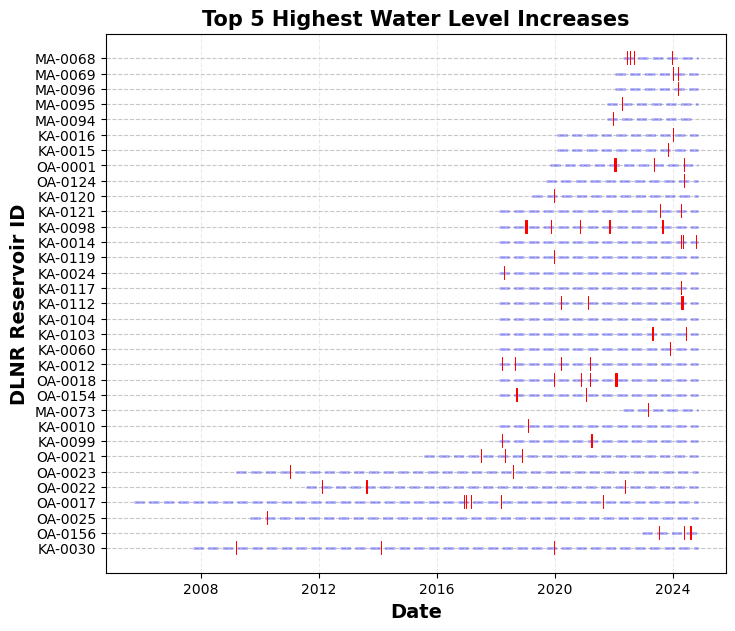

In [65]:
fig, ax = plt.subplots(figsize=(8,7))

data_info = data_info.set_index('dlnrid')
slope_categorization = slope_categorization.set_index('dlnrid')

#plot duration of data
for ID in slope_categorization.index:
    dlnrid = ID
    a = ax.hlines(y= dlnrid, xmin = data_info.start_date[dlnrid], xmax = data_info.end_date[dlnrid], alpha = 0.3, linestyle = '--', color = 'blue', lw = 2)
    st = slope_categorization.start_dates[dlnrid].tolist()
    en = slope_categorization.end_dates[dlnrid].tolist()
    for i in range(len(st)):
        b = ax.hlines(y= dlnrid, xmin = st[i], xmax = en[i], alpha = 1, color = 'red', lw = 10)
    
#title and axis labels
ax.set_title('Top 5 Highest Water Level Increases', fontweight = 'bold', fontsize = 15)
ax.set_ylabel('DLNR Reservoir ID', weight = 'bold', fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)

#plot the dash lines 
a = plt.grid(alpha = 0.25, linestyle = '--', which =  'both', axis = 'x')
b = plt.grid(alpha = 0.7, linestyle = '--', which =  'both', axis = 'y')
#b = plt.grid(alpha = 0.14, linestyle = '--', color = 'r', axis = 'y', lw = '2')

#slope_categorization = slope_categorization.reset_index()
#data_info = data_info.reset_index()


# Classify the slopes into slow and fast categories

In [66]:
slope_categorization = slope_categorization.reset_index()

#quantify the risk of WL increase
slope_categorization['WL_pos_change_potential'] = None
for i in range(len(slope_categorization)):
    if slope_categorization['avg_max_inc_%WLchange'][i] > 3:
        slope_categorization.loc[i, 'WL_pos_change_potential'] = 'FAST'
    else: 
        slope_categorization.loc[i, 'WL_pos_change_potential'] = 'SLOW'


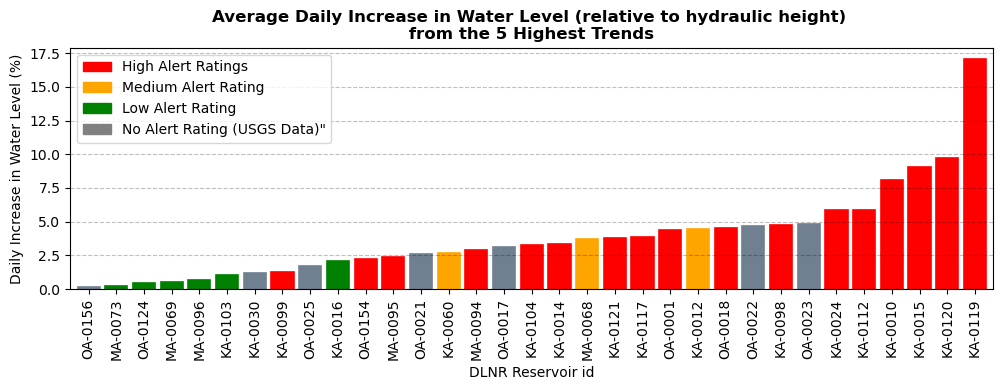

In [77]:
import matplotlib.patches as mpatches
#Create Barplot:
fig, ax = plt.subplots(figsize=(10, 4))

#bars
slope_categorization= slope_categorization.sort_values( by = 'avg_max_inc_%WLchange')
rects = ax.bar(slope_categorization.dlnrid, slope_categorization['avg_max_inc_%WLchange'], edgecolor='black', linewidth=1.2)
#colors of alert ratings
colors={'HIGH' : 'red', 'MEDIUM' : 'orange', 'LOW' : 'green', 'NA' : 'slategrey'} 
for i in range(len(slope_categorization)):
    rects[i].set_color(colors[slope_categorization.hydrologic_response[i]])
plt.xticks(rotation=90, ha='center')
plt.bar

#labels
plt.title('Average Daily Increase in Water Level (relative to hydraulic height) \n from the 5 Highest Trends ', fontweight  = 'bold')
ax.set_xlabel('DLNR Reservoir id')
ax.set_ylabel('Daily Increase in Water Level (%)')


red_patch = mpatches.Patch(color='red', label='High Alert Ratings')
orange_patch = mpatches.Patch(color='orange', label='Medium Alert Rating')
green_patch = mpatches.Patch(color='green', label='Low Alert Rating')
grey_patch = mpatches.Patch(color='grey', label='No Alert Rating (USGS Data)"')
ax.legend(handles=[red_patch, orange_patch, green_patch, grey_patch])

#margins and stuff
ax.margins(x=0.008, y=0.05)
plt.tight_layout()
plt.grid(color='black', which='major', axis='y', linestyle='dashed', alpha = 0.25)
plt.savefig(os.path.join(figures_path, 'Highest_WL_increasing_trends.png'))


# Seasonal Differences in WL Increases

In [71]:
slope_categorization = slope_categorization.set_index('dlnrid')

C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\1874658120.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  st = slope_categorization.start_dates[dlnrid].tolist()
C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\1874658120.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  en = slope_categorization.end_dates[dlnrid].tolist()


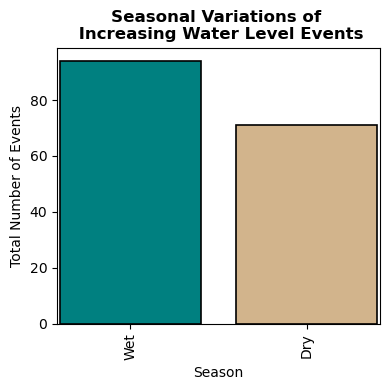

In [73]:
slope_categorization = slope_categorization.set_index('dlnrid')

all_starts = []
all_ends = []
all_seasons = []
all_dlnrid = []

for i in data_info.index:
    dlnrid = i
    st = slope_categorization.start_dates[dlnrid].tolist()
    en = slope_categorization.end_dates[dlnrid].tolist()

    months = []
    for i in st:
        if i.month >= 11:
            month = 'rainy'
        elif i.month < 4:
            month = 'rainy'
        else:
            month = 'dry'
        months.append(month)
   
    all_starts.append(st)
    all_seasons.append(months)
    all_ends.append(en)
    all_dlnrid.append(dlnrid)

dict1 = {'start' : all_starts, 'end': all_ends, 'seasons' : all_seasons, 'dlnrid' : all_dlnrid}
df = pd.DataFrame(dict1)
rainy = 0
dry = 0 

for i in df.index:
    for x in df.seasons[i]:
        if x == 'rainy':
            rainy+= 1
        if x == 'dry':
            dry += 1

#Create Barplot:
fig, ax = plt.subplots(figsize=(4, 4))

#bars
rects = ax.bar(['Wet', 'Dry'], [rainy, dry], color = ['teal', 'tan'], edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.bar

#labels
plt.title('Seasonal Variations of \n Increasing Water Level Events', fontweight  = 'bold')
ax.set_xlabel('Season')
ax.set_ylabel('Total Number of Events')

#margins and stuff
ax.margins(x=0.008, y=0.05)
plt.tight_layout()

plt.savefig(os.path.join(figures_path, 'Seasonal_Variation_Top5_IncreasingWL_Events.png'))

slope_categorization = slope_categorization.reset_index()
data_info = data_info.reset_index()

# Pull out the top 5 WL trend increases

In [ ]:
# import statistics

# Reservoir_Slopes
# ids = []
# Max_WL_trend = []
# Max_WL_increase = []

# for key in Reservoir_Slopes:
#     ids.append(key)
#     df= Reservoir_Slopes[key]
#     df = df.drop('normalized_change_WL', axis=1)
#     df = df.dropna(subset=['avg_WL_change_per_n']) 
#     df['total_change'] = df['n_data'] * df['avg_WL_change_per_n']
#     max_increase = statistics.mean(df.sort_values('total_change')[-6:-1]['total_change'].tolist())
    
#     top5_WL_daily_trend = df.sort_values('avg_WL_change_per_n')[-6:-1]['avg_WL_change_per_n'].tolist()
#     num_days_trend = df.sort_values('avg_WL_change_per_n')[-6:-1]['n_data'].tolist()
# #     total_WL_increase = []
# #     for i in range(len(top5_WL_daily_trend)):
# #         total_WL_increase.append(top5_WL_daily_trend[i] * num_days_trend[i])
#     Max_WL_trend.append(top5_WL_daily_trend)
#     Max_WL_increase.append(max_increase)

#     df= Reservoir_Slopes[key].copy()
#     df = df.drop('normalized_change_WL', axis=1)
#     df = df.dropna(subset=['avg_WL_change_per_n']) 
#     df.sort_values('avg_WL_change_per_n')[-6:-1]['avg_WL_change_per_n']
    
#     Max_WL_increase
    
#     dict = {'dlnrid': ids, 'max_WL_increase': Max_WL_increase} 
       
#     df = pd.DataFrame(dict)
    
#     dict = {'dlnrid': ids, 'top5_maxWL': Max_WL_trend} 
#     top5 = pd.DataFrame(dict)
    
#     df
    
#     #get the dlnrid
#     dlnrid= []
#     Station_Meta = Station_Meta.set_index('id')
    
#     for ID in slope_categorization.Reservoir:
#         dlnrid.append(Station_Meta['properties.dlnrid'][ID])
    
#     df['dlnrid'] = dlnrid
#     Station_Meta = Station_Meta.reset_index()
    
#     #get the hydrologic response from 
#     hydr_resp = []
#     for ID in slope_categorization.Reservoir:
#         hydr_resp.append(hydrologic_response[ID])
    
#     df['hydrologic_response'] = hydr_resp

# Seasonal Variation in Water Level. Some Reservoirs (negative) have higher water levels during the dry season 


In [143]:
Station_Meta = Station_Meta.reset_index()

In [148]:
#create a new dictionary for holding month column
seasonal_daily_WL = daily_WL_ommitted.copy()


for key in seasonal_daily_WL:
    seasonal_daily_WL[key] = seasonal_daily_WL[key].reset_index()
    seasonal_daily_WL[key]['month'] = None
    for i in range(len(seasonal_daily_WL[key])):
        month = seasonal_daily_WL[key].date[i].month
        seasonal_daily_WL[key].loc[i, 'month'] = month  

seasonal_id = [] 
wet_mean = []
dry_mean = []
annual = []
stdev = []


for key in seasonal_daily_WL: 
    seasonal_id.append(key)
    
    df = seasonal_daily_WL[key]

    df['season'] = None
    for i in range(len(df)):
        if df.month[i] >= 11 : 
            df.loc[i, 'season'] = 'wet'
        elif df.month[i] <= 4 : 
            df.loc[i, 'season'] = 'wet' 
        else: 
            df.loc[i, 'season'] = 'dry' 


    annual.append(df.data.mean())
    stdev.append(df.data.std())
    dry = df.loc[(df['season'] == 'dry')]
    dry_mean.append(dry.data.mean())

    wet = df.loc[(df['season'] == 'wet')]
    wet_mean.append(wet.data.mean())
    
# dictionary of lists 
seasonal_stats = pd.DataFrame({'UHSLC_USGS_id': seasonal_id, 'dry_mean': dry_mean, 'wet_mean': wet_mean , 'annual' : annual, 'stdev' : stdev} )
   
#other stats
seasonal_stats['seasonal_diff_in_std'] = (seasonal_stats['wet_mean'] - seasonal_stats['dry_mean']) / seasonal_stats['stdev']
seasonal_stats['wet_season_difference'] = seasonal_stats['wet_mean'] - seasonal_stats['annual']
seasonal_stats['dry_season_difference'] = seasonal_stats['dry_mean'] - seasonal_stats['annual']

# #get dlnrid 

seasonal_stats = seasonal_stats.set_index('UHSLC_USGS_id')
seasonal_stats['dlnrid'] = None
Station_Meta = Station_Meta.set_index('id')
for i in Station_Meta.index: 
    dlnrid = Station_Meta['properties.dlnrid'][i]
    seasonal_stats.loc[i, 'dlnrid'] = dlnrid
    
seasonal_stats = seasonal_stats.reset_index()
Station_Meta = Station_Meta.reset_index()

seasonal_stats.to_csv(os.path.join(tables_path, 'seasonal_stats.csv'))

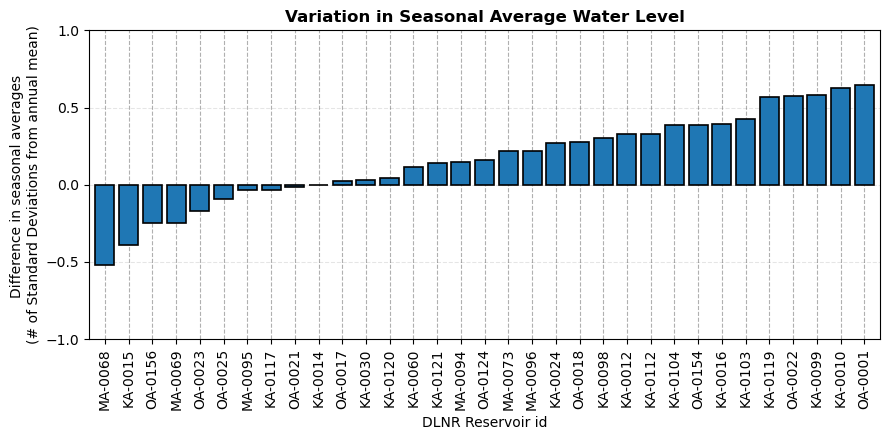

In [150]:
seasonal_stats = seasonal_stats.sort_values('seasonal_diff_in_std')

# #Create Barplot:
fig, ax = plt.subplots(figsize=(9, 4.5))




#bar graphs
rects = ax.bar(seasonal_stats.dlnrid, seasonal_stats.seasonal_diff_in_std, edgecolor='black', linewidth=1.2)
plt.xticks(rotation=90, ha='center')
plt.yticks(np.arange(-1.5, 2, 0.5))


#labels and margins
plt.title('Variation in Seasonal Average Water Level', fontweight  = 'bold')
ax.set_xlabel('DLNR Reservoir id')
ax.set_ylabel('Difference in seasonal averages \n(# of Standard Deviations from annual mean)')

ax.set_ylim([-1, 1])
ax.margins(x=0.008, y=0.05)

plt.tight_layout()
ax.grid(color='black', which='major', axis='y', linestyle='dashed', alpha = 0.25, zorder = 0)
ax.grid(alpha = 1, linestyle = '--', which =  'both', axis = 'x', zorder = 0)
ax.grid(alpha = 0.1, linestyle = '--', which =  'both', axis = 'y', zorder = 0)


ax.set_axisbelow(True)


plt.savefig(os.path.join(figures_path, 'seasonal_variation.png'))

# Tables for report:

ALL tables from earlier 
stats_df #stats, result #data duration and completeness, hydrologic_response_dlnrid #alert level response rating, slope_categorization #slope values, seasonal_stats #seasonal stuff

sort all by DLNRID

Appendix A Alert Levels for UHSLC Reservoirs
DLNR ID, start alert, end alert

Appendix B Reservoir Classification
DLRNID, Trend rating, average Increase, alert rating

Appendix C
DLNRID, Reservoir Name, data source, completeness of data, duration, start date, end date

Appendix D
station stats

In [80]:
#OUTPUT PATH
Report_tables_path = os.path.join(".", "Outputs", "Report_Tables") #.to_csv(os.path.join(tables_path, 'test.csv'))


#APPENDIX A Alert Levels for UHSLC Reservoirs
#DLNR ID, start alert, end alert
RT_Alert_Levels = pd.DataFrame()
RT_Alert_Levels['DLNR ID'] = Station_Meta['properties.dlnrid'].copy()
RT_Alert_Levels['Alert ON (ft)'] = Station_Meta['properties.level_alert_on'].copy()
RT_Alert_Levels['Alert OFF (ft)'] = Station_Meta['properties.level_alert_off'].copy()
RT_Alert_Levels = RT_Alert_Levels.sort_values('DLNR ID')
RT_Alert_Levels.to_csv(os.path.join(Report_tables_path, 'RT_Alert_Levels.csv'))


#APPENDIX B Reservoir Classification
RT_alert_rating  = hydrologic_response_dlnrid.copy()
#classify alerts
for i in range(len(RT_alert_rating)):
    if RT_alert_rating['response_rating'][i] == 'hazard':
        RT_alert_rating.loc[i, 'response_rating'] = 'HIGH'
    if RT_alert_rating['response_rating'][i] == 'problem':
        RT_alert_rating.loc[i, 'response_rating'] = 'MEDIUM'
    if RT_alert_rating['response_rating'][i] == 'safe':
        RT_alert_rating.loc[i, 'response_rating']  = 'HIGH'
#change columns
RT_alert_rating = RT_alert_rating.rename(columns={'response_rating': 'Alert Rating', 'dlnrid': 'DLNR ID'})
#get the %change value from calculations
RT_alert_rating = RT_alert_rating.set_index('DLNR ID')
slope_categorization = slope_categorization.set_index('dlnrid')
RT_alert_rating['Increasing Water Levels'] = None
for i in RT_alert_rating.index:
    RT_alert_rating.loc[i , 'Increasing Water Levels'] = slope_categorization['WL_pos_change_potential'][i]
#sort with DLNR ID
RT_alert_rating = RT_alert_rating.sort_values('DLNR ID')
RT_alert_rating.to_csv(os.path.join(Report_tables_path, 'RT_alert_rating.csv'))
slope_categorization = slope_categorization.reset_index()
RT_alert_rating = RT_alert_rating.reset_index()


#APPENDIX C metadata stuff
#pull meta data 
RT_reservoir_meta = result.copy()
#rename columns
RT_reservoir_meta = RT_reservoir_meta.rename(columns={'dlnrid': 'DLNR ID', 'end_date': 'End Date', 'start_date' : 'Start Date', 'duration': 'Duration (yr)', 'completeness' : 'Completeness (%)'})
#turn completeness data into percentage and round both duration and completeness
RT_reservoir_meta['Completeness (%)'] = (RT_reservoir_meta['Completeness (%)']*100).round(decimals = 0)
RT_reservoir_meta['Duration (yr)'] = (RT_reservoir_meta['Duration (yr)']).round(decimals = 1)
#get official dam names for each reservoir from the DLNR website
all_reservoir_names = pd.read_csv(os.path.join("..", "Data", "Metadata_Sheets", 'ALL_HI_reservoirs_Metadata.csv'))
all_reservoir_names = all_reservoir_names.set_index('state_id')
RT_reservoir_meta = RT_reservoir_meta.set_index('DLNR ID')
RT_reservoir_meta['Name of Reservoir'] = None
for i in RT_reservoir_meta.index:
    RT_reservoir_meta.loc[i, 'Name of Reservoir'] = all_reservoir_names['dam_name'][i]
#drop unimportant columns
RT_reservoir_meta = RT_reservoir_meta.drop(['Reservoir_station_file'], axis = 1)	
#sort with DLNRID
RT_reservoir_meta = RT_reservoir_meta.sort_values('DLNR ID')
RT_reservoir_meta.to_csv(os.path.join(Report_tables_path, 'RT_reservoir_meta.csv'))
RT_reservoir_meta = RT_reservoir_meta.reset_index()


#APPENDIX D stats table
RT_WL_stats = stats_df.copy()
#rename columns
RT_WL_stats = RT_WL_stats.rename(columns={'dlrnid': 'DLNR ID', 'mean': 'Avg (ft)', 'minimum' : 'Min (ft)', 'maximum': 'Max (ft)', 'median' : 'Med (ft)', 'standard_deviation' : 'Std (ft)'})
#drop unimportant columns
RT_WL_stats = RT_WL_stats.drop(['file_id'], axis = 1)	
#Round
RT_WL_stats['Avg (ft)'] = RT_WL_stats['Avg (ft)'].round(decimals = 1)
RT_WL_stats['Std (ft)'] = RT_WL_stats['Std (ft)'].round(decimals = 2)
RT_WL_stats['Med (ft)'] = RT_WL_stats['Med (ft)'].round(decimals = 1)
RT_WL_stats['Min (ft)'] = RT_WL_stats['Min (ft)'].round(decimals = 1)
RT_WL_stats['Max (ft)'] = RT_WL_stats['Max (ft)'].round(decimals = 1)
#sort values
RT_WL_stats = RT_WL_stats.sort_values('DLNR ID')
RT_WL_stats.to_csv(os.path.join(Report_tables_path, 'RT_WL_stats.csv'))

## Read In the Precip data from HCDP 

In [81]:
RainData = pd.read_csv(os.path.join("..", 'Data/HCDP_Rainfall_Daily_Data', "HCDP_RainData2018-2024.csv"))
RainData = RainData.set_index("index")   # make sure the index is date
RainData.index = pd.to_datetime(RainData.index, errors='coerce')


RainData_Meta = pd.read_csv(os.path.join("..", 'Data/HCDP_Rainfall_Daily_Data', "HCDP_Rain_METADATA_2018-2024.csv"))

# First make Arc read it as a string 
RainData_Meta["SKN"] = RainData_Meta["SKN"].astype(str)+"_R"  
RainData_Meta.to_csv(os.path.join("..", 'Data/HCDP_Rainfall_Daily_Data', "HCDP_Rain_METADATA_2018-2024_ArcrReady.csv"))

## Went into Arc to create the near table
- Used RainData_Meta_v2.csv, cleared out useless columns to make RainData_Meta_v2_Clean.csv. 
- Then manually merged UHSLC_Station_Metadata.csv, and USGS_ID_Meta.xlsx, so they only had the station names and lat lon and IDs. 
- In Arc brought in, turned to shapefiles, then near table tool on the Reservoirs, selecting only the 10 closest rain station points.  
- Arc only records the FIDs so have to do 2 joins on the original tables. 
- Result is Res_Rain_Near_Table_New_v2.csv, after 30 minutes of wasted time \

In [82]:
near_table = pd.read_csv(os.path.join("..", "Data/Metadata_Sheets", "Res_Rain_Near_Table_New_v2.csv"))

## Import metadata
Station_Meta = pd.read_csv("Station_meta.csv")

C:\Users\bgorb\AppData\Local\Temp\ipykernel_30896\2129323857.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,3))


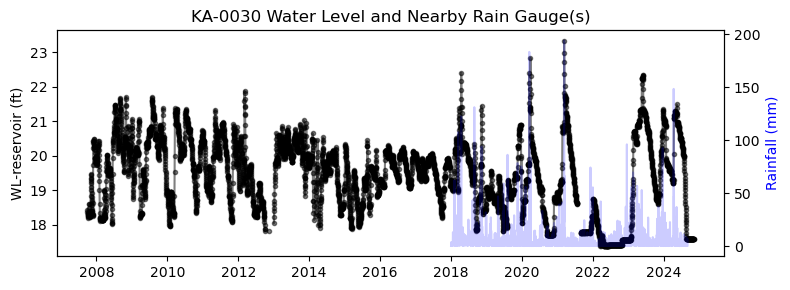

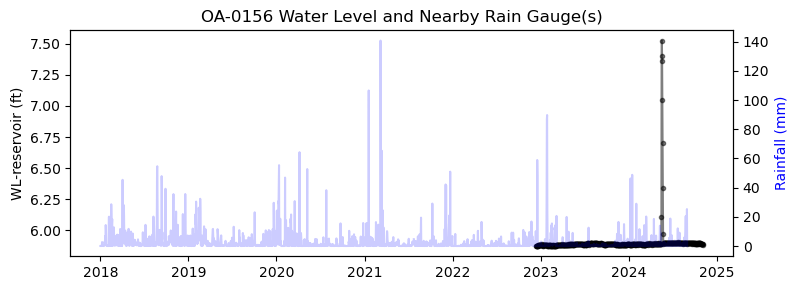

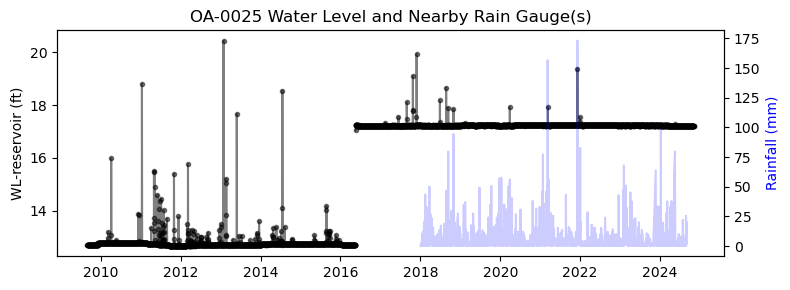

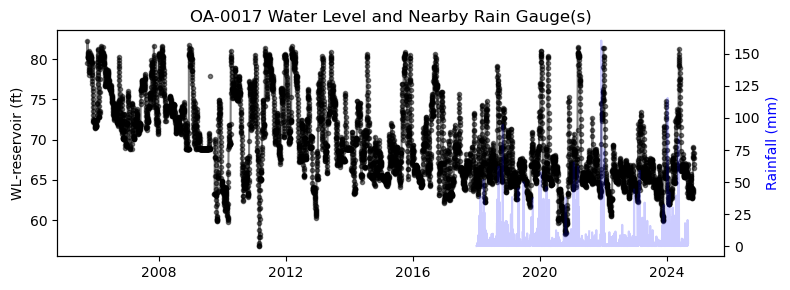

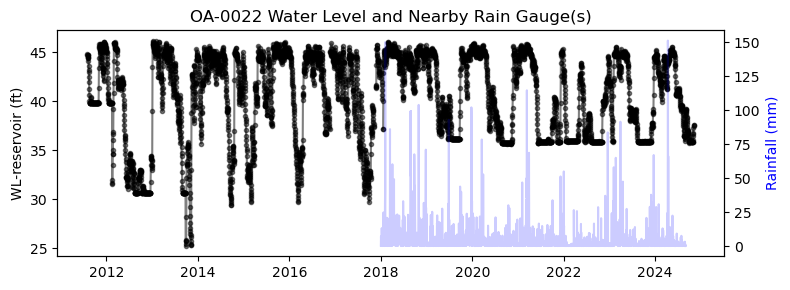

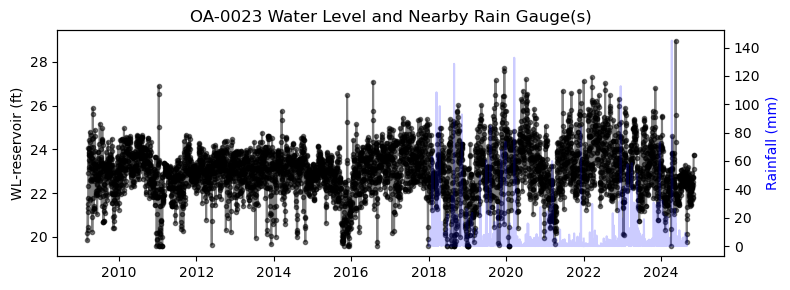

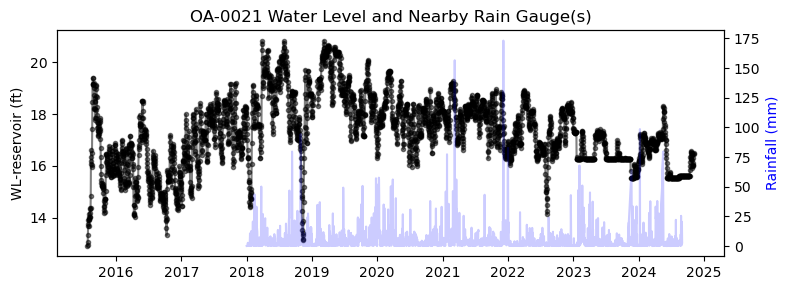

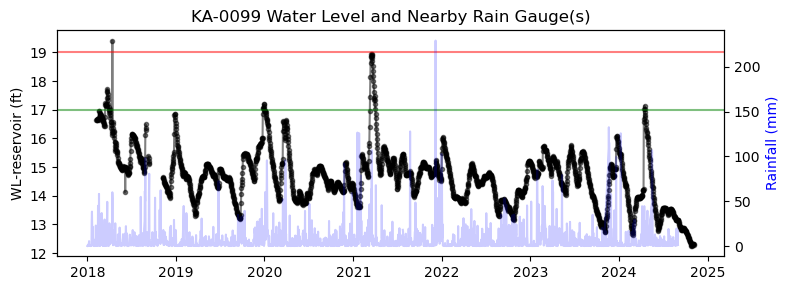

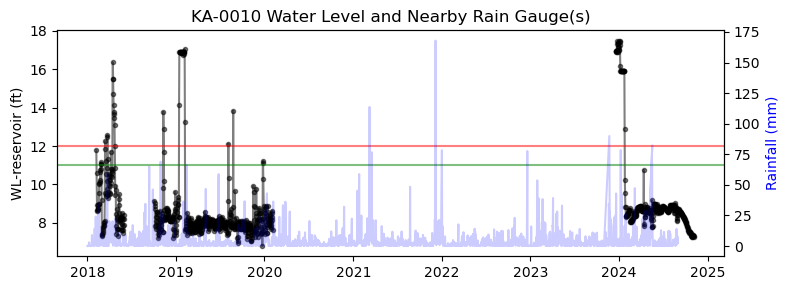

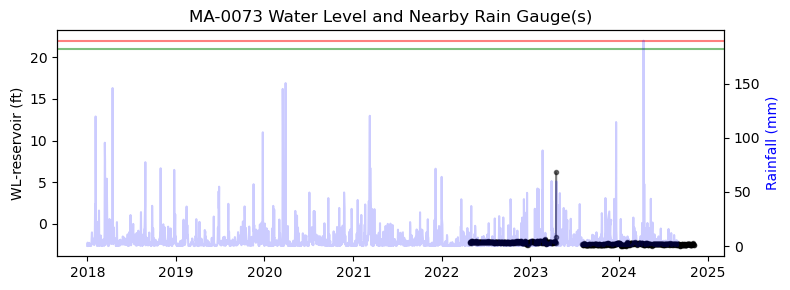

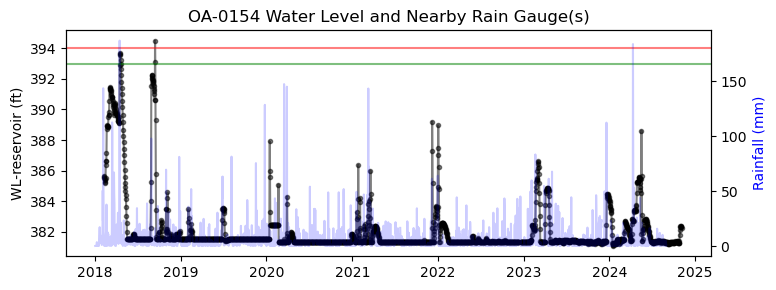

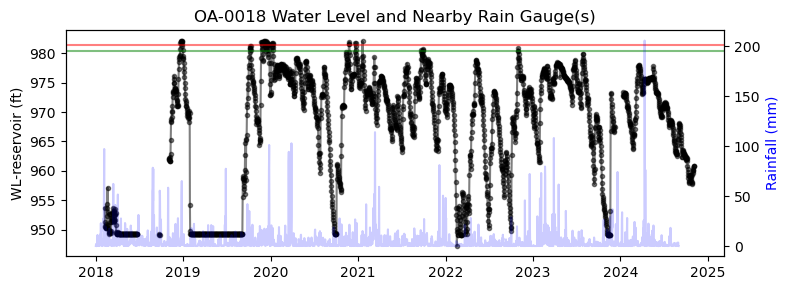

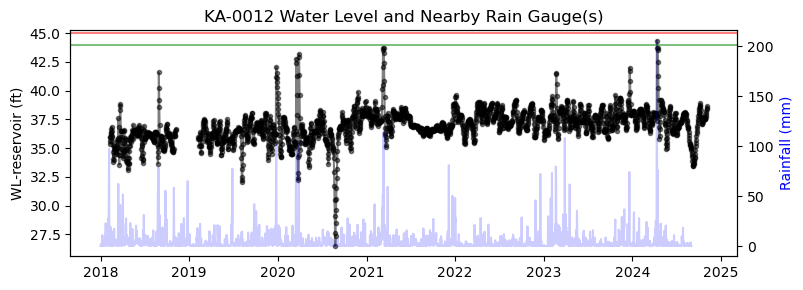

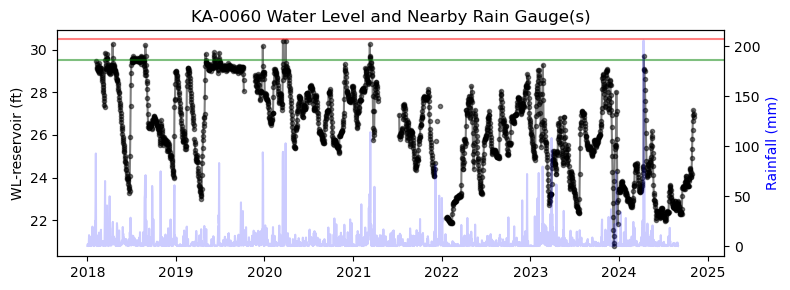

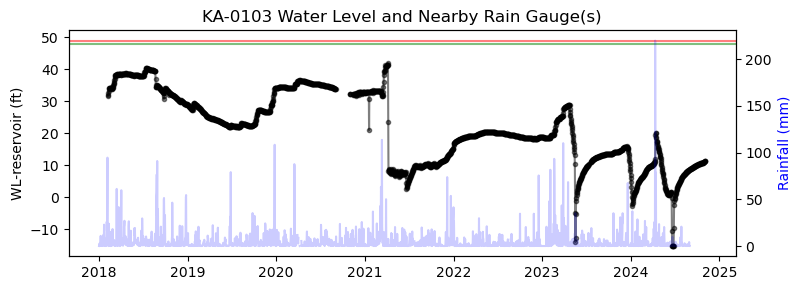

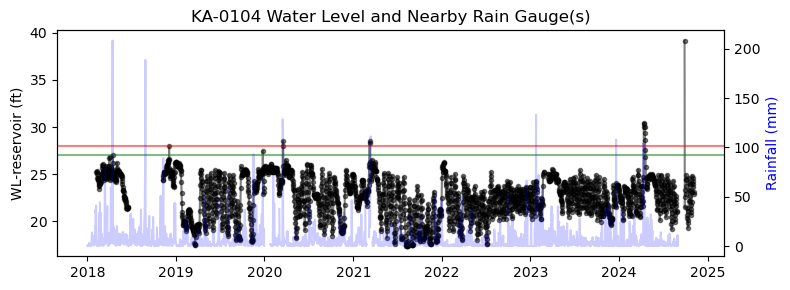

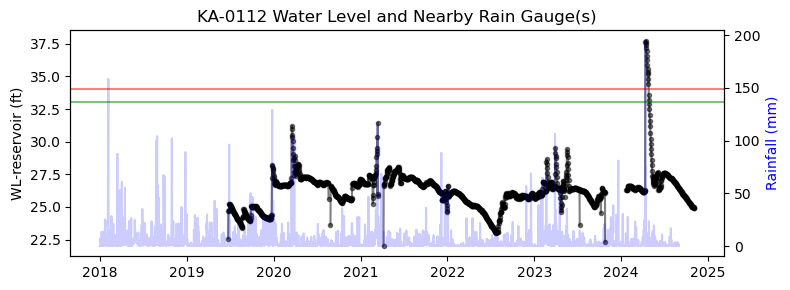

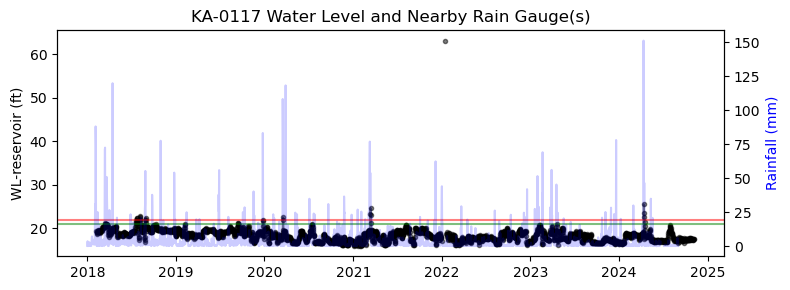

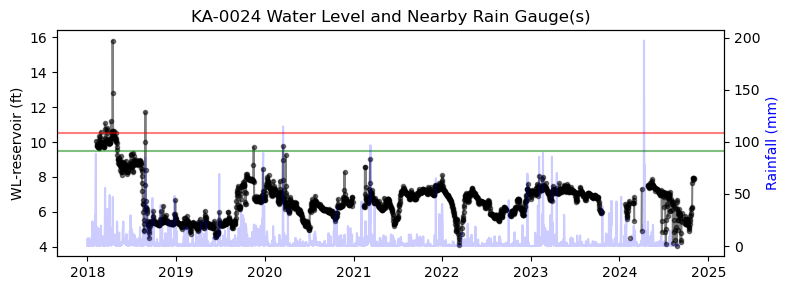

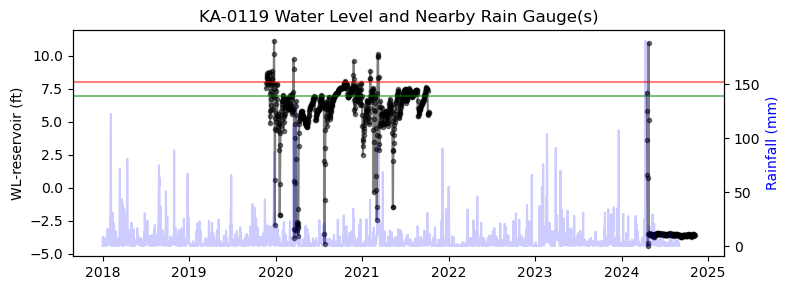

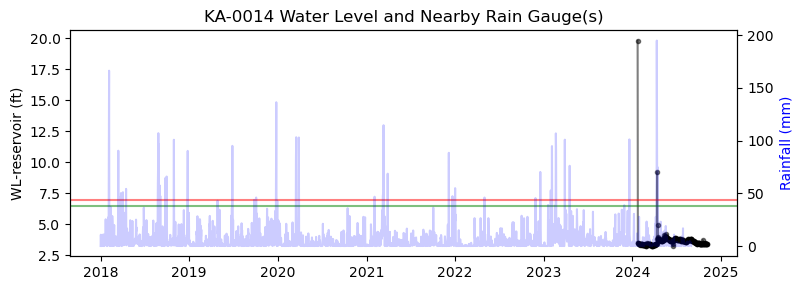

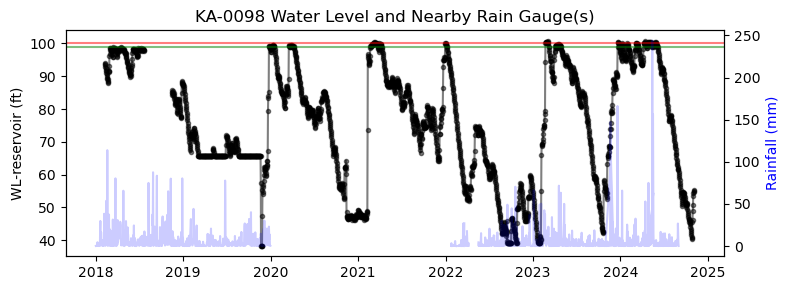

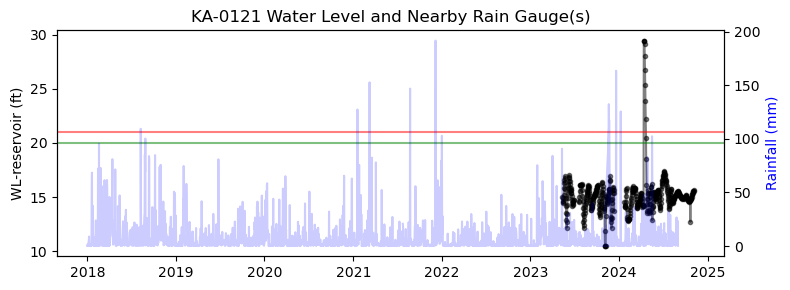

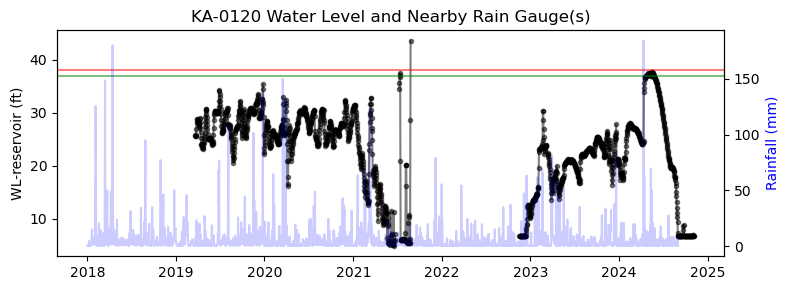

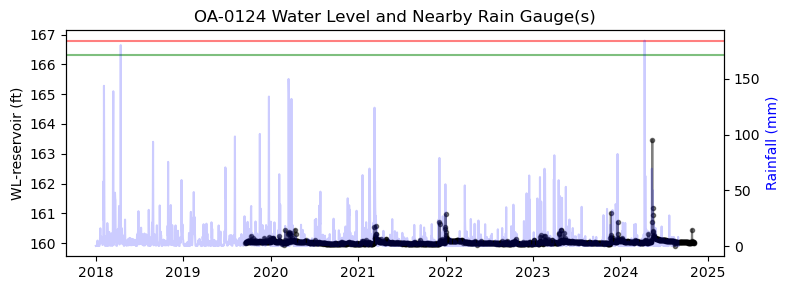

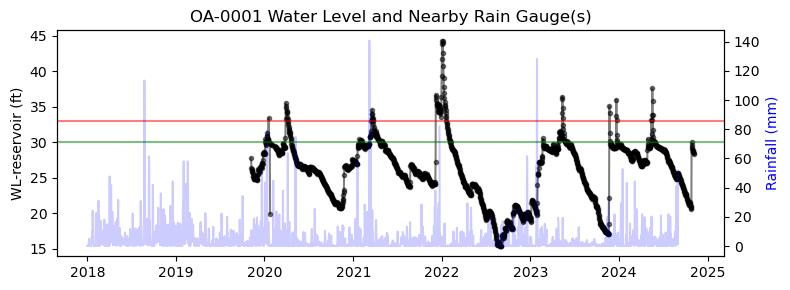

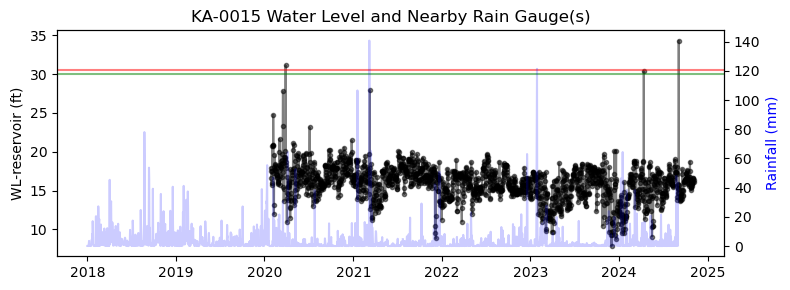

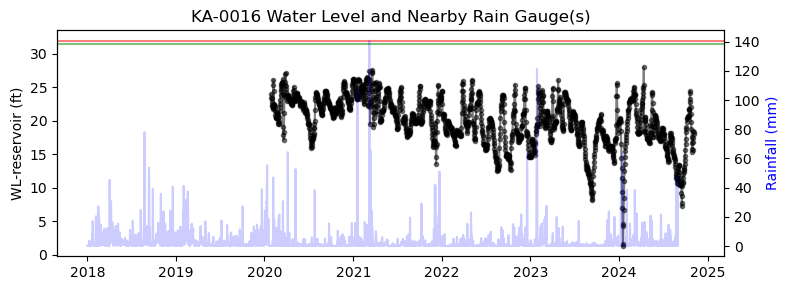

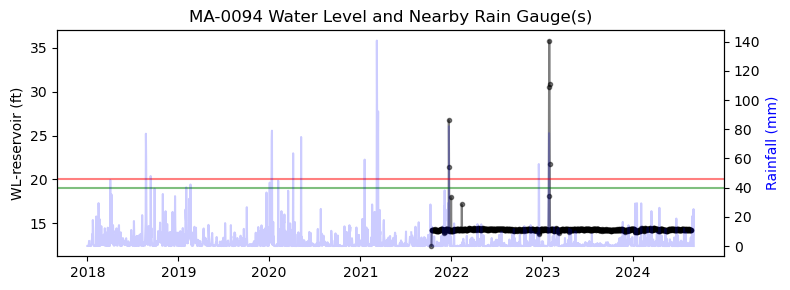

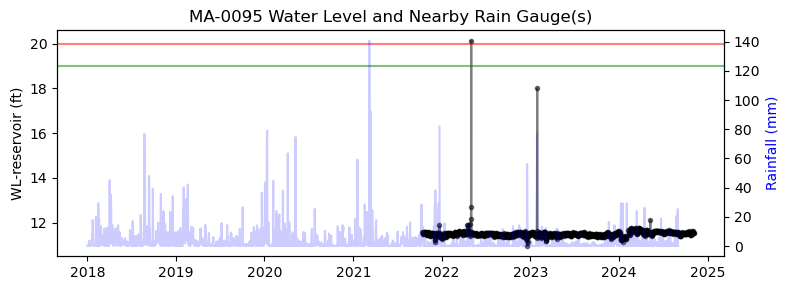

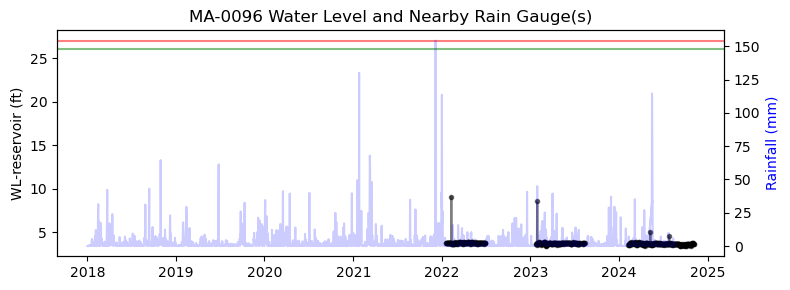

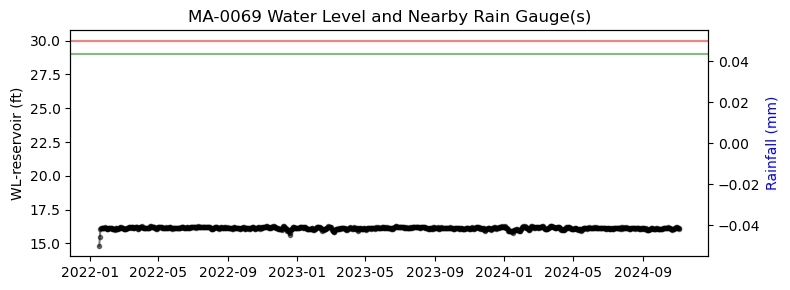

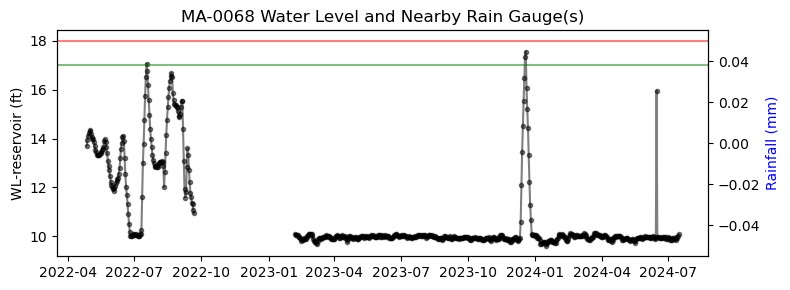

In [129]:
#smalldic = {key: daily_dic[key] for key in ['EDD00214.csv', 'EDD00CC6.csv', 'EDD024F8.csv', 'USGS_213133158014201.csv']}   # For testing 

# Paramater that changes how many near rainfall stations to use 
Nearest_X_Stations = 10

Station_Meta = Station_Meta.set_index('id')
for i in daily_WL_ommitted.keys():  #daily_WL_ommitted.keys(): 
    stat_id = Station_Meta['properties.dlnrid'][i]
    #### Modify for USGS 
    isla = stat_id.split('-')[0]  # Pull out the island from the dlnr ID
    
    fig, ax = plt.subplots(figsize=(8,3))
    plt.plot(daily_WL_ommitted[i].date, daily_WL_ommitted[i].data, marker=".", color='k', alpha=0.5, label="WL_(ft)")
    
    # Add the lever alert lines
    Level_alert_on = Station_Meta['properties.level_alert_on'][i] 
    plt.axhline(y=Level_alert_on, color='r', linestyle='-', alpha = 0.5)   
    Level_alert_off = Station_Meta['properties.level_alert_off'][i]
    plt.axhline(y=Level_alert_off, color='g', linestyle='-', alpha = 0.5)
    
    
    nearest_SKN_table = near_table[near_table['ID'] == i]     # Reference the nearest stations for rainfall
    nearest_X_SKNs =  nearest_SKN_table[nearest_SKN_table['NEAR_RANK'] <= Nearest_X_Stations]  # Cut to the number specified in Nearest_X_Stations
    nearest5skns = list(nearest_X_SKNs['SKN'])                      # Pull out the SKN vales from the dataframe 
    nearest5skns = list(map(lambda x: x.split("_")[0], nearest5skns))  # Quick list function map to pull of the "_R" from each SKN
    nearest5skns = list(map(lambda x: str(x), nearest5skns))  # Quick list function map to turn values back into str
    rain_datatoplot_5 = RainData[nearest5skns]     # make it a single dataframe 
    rain_datatoplot_5_mean = rain_datatoplot_5.mean(axis=1)    # calculate the average rainfall over all N stations 
    
    # Plot Rain Data
    ax2=ax.twinx()
    rain_datatoplot_5_mean.plot(ax=ax2, color='b', alpha=0.2)
    
    plt.title(stat_id +" Water Level and Nearby Rain Gauge(s)") 
    ax2.set_ylabel('Rainfall (mm)', color='b')
    ax.set_ylabel('WL-reservoir (ft)', color='k')
    plt.savefig('res.png')
    plt.tight_layout()
Station_Meta = Station_Meta.reset_index()

# Rain Gauge and WL patterns

In [ ]:
#rain gauges worth exploring: USGS 220443149235601 and KA-0060
